In [1]:
%%HTML
<script src="require.js"></script>

In [2]:
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
HTML('''<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script><script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
} else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

<img src='movie-night-banner.png'>

<a id='Abstract'></a>
<h1 style="color:#ffffff; background-color:#E44728; border: 1px solid #ffffff; padding: 10px 10px 10px 10px;">ABSTRACT</h1>

In the era of abundant streaming services, finding similar movies after watching one poses a challenge. Relying solely on genre for recommendations may disappoint users, as it overlooks nuanced, less straightforward, and less obvious features, potentially suggesting irrelevant films despite sharing a genre. Hence, using all the features of movie as a query instead, which is the underpinning of an Information Retrieval System for movies, a type of movie recommender system, would help in addressing the lack of nuance provided by solely genre-based movie recommenders. With respect to this, our study aims to explore what potential characteristics, features, and parameters makes an Information Retrieval System, which is based on a movie dataset, effective.

The team processed a dataset comprising 128 movies scraped from Rotten Tomatoes, employing techniques like one-hot encoding, TFIDF-normalization, and Min-Max Normalization for data cleaning. Within this dataset, Drama emerged as the most frequent genre, and English was the most commonly used language. The movie list was purposely limited in order to make evaluating the effectiveness of the Information Retrieval systems feasible. 

Two Information Retrieval systems were then created with different "optimized" vectorizer settings (which included stemming, word normalization, setting the maximum and minimum document frequency requirements, and such) and with default vectorizer settings. These were further divided by distance measures which included Euclidean, Manhattan, and Cosine distance measures.

In evaluating the variants, the most optimal k parameter was determined using a Precision-Recall vs. k graph, informing Average Precision, Average Recall, and Average F-1 score at k. Additional metrics encompassed Mean Average Precision, R-Precision, and Eleven-Point Precision-Recall Curve. Key findings indicated that the default setting is optimal (1), cosine distance is the preferred measure (2), larger datasets lead to higher metrics (3), and a k of 5 is roughly the optimal number of results (4). Moreover, analyzing the R-Precision of each query, it was found that increasing the number of queries would account for coincidentally well-representative queries and less-representative queries in the queries, thereby removing the possible skew in the metrics, and that increasing the data points lead to higher metrics due to having more chances of acquiring salient features for a given characteristic of the data points.

Recommendations for future studies include increasing the size of the dataset (1), creating hypotheses for each change in setting (2), increasing the number of test queries (3), improving the gold standard by outsourcing external "movie watchers" (4), and comparing cosine distance with other distance measures not studied in this report (5). This would allow for a more extensive exploration and discussion of the interplay among the characteristics of the Information Retrieval System, the characteristics of its dataset, and the entertainment domain, through which the most optimal settings are found for movie recommender systems and through which a better movie recommender system is created.

<a id='Libraries'></a>
<h1 style="color:#ffffff; background-color:#E44728; border: 1px solid #ffffff; padding: 10px 10px 10px 10px;">IMPORT LIBRARIES AND DEFINE FUNCTIONS</h1>

<h2 style="color: #5BC461">Import Libraries</h2>
<p>The following libraries and functions were imported:</p>
<ul>
    <li><b>Pandas</b> for managing dataframes and tabular data</li>
    <li><b>Requests</b> for acquiring access to the relevant Rotten Tomatoes webpages</li>
    <li><b>Beautiful Soup 4</b> for scraping the Rotten Tomatoes webpages</li>
    <li><b>Regular Expression</b> for utilizing patterns with the HTML script during scraping</li>
    <li><b>OS</b> for managing downloaded webpages from Rotten Tomatoes</li>
    <li><b>SQLite3</b> for accessing and querying created databases</li>
    <li><b>sklearn's CountVectorizer</b> for vectorizing document columns</li>
    <li><b>nltk's EnglishStemmer</b> for stemming the words in the documents</li>
    <li><b>sklearn's TfidfTransformer</b> for normalizing the token frequencies into TF-IDF</li>
    <li><b>matplotlib's pyplot</b> for plotting some of the relevant visualizations in the paper</li>
    <li><b>Seaborn</b> for plotting the other relevant visualizations in the paper</li>
    <li><b>sklearn's MinMaxScaler</b> for scaling the continuous variables</li>
    <li><b>Warnings</b> for hiding the warnings and cleaning the notebook</li>
    <li><b>scipy's distance module</b> for measuring distance metrics</li>
    <li><b>scipy's trapz</b> for calculating the area under the curve</li>
    <li><b>Numpy</b> for faster manipulation of matrices</li>
    <li><b>IPython</b> for displaying purposes</li>
    <li><b>ipywidgets</b> for creating interactive widgets</li>
</ul>

In [252]:
import pandas as pd
import bs4
import requests
import re
import os
import sqlite3
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import EnglishStemmer
from sklearn.feature_extraction.text import TfidfTransformer
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.spatial.distance import euclidean, cityblock, cosine
from scipy.integrate import trapz
import warnings
import seaborn as sns

<h2 style="color: #5BC461">Define Functions</h2>
<p>The following functions were defined:</p>
<ul>
    <li><b>get_info</b> for getting the information for each movie, coming from an HTML file</li>
    <li><b>get_all_movie_info</b> for creating a dataframe for the movies' details</li>
    <li><b>one_hot_encode</b> for one-hot encoding all categorical columns</li>
    <li><b>movie_sql</b> for creating and updating a database from the collected and processed data</li>
    <li><b>load_sql</b> for converting the table in the database to a dataframe</li>
    <li><b>sort_idf</b> for acquiring the idf of each token and collecting additional potential stopwords</li>
    <li><b>preprocessor</b> for preprocessing the documents</li>
    <li><b>bag_of_words</b> for converting documents into bag-of-words</li>
    <li><b>normalize_tfidf</b> for normalizing bag-of-word vectors to TFIDF</li>
    <li><b>nearest_k</b> for returning the results of the IR</li>
    <li><b>kappa</b> for calculating the kappa statistic and presenting the relevance matrix</li>
    <li><b>pk</b> for calculating the Precision @ k</li>
    <li><b>a_pk</b> for calculating the Average (Precision @ K)</li>
    <li><b>rk</b> for calculating the Recall @ k</li>
    <li><b>a_rk</b> for calculating the Average (Recall @ k)</li>
    <li><b>apk</b> for calculating the Average Precision @ k</li>
    <li><b>mapk</b> for calculating the Mean Average Precision @ k</li>
    <li><b>mf_onek</b> for calculating the Mean F-1 Score @ k</li>
    <li><b>rprec</b> for calculating the individual R-Precisions</li>
    <li><b>ave_rprec</b> for calculating the Average R-Precision</li>
    <li><b>ave_prg</b> for plotting the 11-point Precision/Recall graph</li>
    <li><b>pretty_print</b> for printing dataframes more cleanly</li>
    <li><b>recommend</b> for recommeding movie titles based on a title</li>
    <li><b>search_k_title</b> for listing all relevant movies based on k and title</li>
</ul>

In [253]:
def get_info(html_file):
    """Get the information for each movie, which comes from an html file.

    Parameters
    -------
    html_file : str
        Name of html file

    Returns
    -------
    mydict : dict
        Dictionary which contains all features of a movie
    """
    with open(html_file) as f:
        html_content = f.read()

    soup = bs4.BeautifulSoup(html_content)

    title = soup.head.title.text.replace(' - Rotten Tomatoes', '')

    synopsis = soup.find('p', {'data-qa': 'movie-info-synopsis'}).text

    genre_raw = soup.find('span', {'class': 'genre'}).text
    genre = genre_raw.replace('\n', '').replace(' ', '').split(',')

    runtime_raw = soup.find('b', string='Runtime:').find_parent() \
        .find('span').find('time').text.strip()
    match = re.match(r'(\d+)h (\d+)m', runtime_raw)
    runtime = int(match.group(1)) * 60 + int(match.group(2)) if match else 0

    language = soup.find('b', string='Original Language:') \
        .find_parent().find('span').text

    top_critics = soup.find_all(
        'review-speech-balloon-deprecated',
        {'istopcritic': 'true'}
    )
    critic = '\n\n'.join(tc.get('reviewquote', '') for tc in top_critics)

    mydict = {
        'title': title,
        'synopsis': synopsis,
        'genre': genre,
        'runtime': runtime,
        'language': language,
        'critic': critic
    }

    return mydict

In [254]:
def get_all_movie_info():
    """Create a dataframe for the movies' details.

    Returns
    -------
    df
        Data Frame containing all the movies' details
    """
    movie_list = []
    folder_path = "movies"

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if os.path.isfile(file_path):
            movie_list.append(get_info(file_path))
            print('done with ', file_path)

    return pd.DataFrame(movie_list)

In [255]:
def one_hot_encode(movies):
    """For categorical columns, such as genre and language, one-hot-encode
    them. And return the new dataframe with one-hot-encoded categorical
    variables.

    Parameters
    -------
    movies : df
        Data Frame containing all the movies and their features

    Returns
    -------
    movies_encoded : df
        Data Frame where the categorical features from the original Data Frame
        are one-hot encoded
    """
    genre_dummies = pd.get_dummies(
        movies['genre'].apply(pd.Series).stack()).groupby(level=0).sum()
    genre_dummies = genre_dummies.add_prefix('g_')

    language_dummies = pd.get_dummies(
        movies['language'], dtype='int').add_prefix('lang_')

    movies_encoded = pd.concat([movies, genre_dummies, language_dummies],
                               axis=1)
    movies_encoded.drop(['genre', 'language'], axis=1, inplace=True)
    movies_encoded.columns = movies_encoded.columns.str.lower()

    return movies_encoded

In [256]:
def movie_sql(df):
    """Create a table from a Data Frame which will be placed inside a
    SQLite3 database

    Parameters
    -------
    df : df
        Data Frame containing all the movies and their features
    """
    db_file = 'rotten_tomatoes.db'
    conn = sqlite3.connect(db_file)
    df.to_sql('movie_encoded', conn, index=False, if_exists='replace',)
    conn.close()

In [257]:
def load_sql(db='rotten_tomatoes.db'):
    """Return the Data Frame from the table in the SQLite3 database

    Parameters
    -------
    db : str, optional
        Name of the SQLite3 database

    Returns
    -------
    df : df
        Data Frame which was loaded from the SQLite3 database
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    df = pd.read_sql("SELECT * FROM movie_encoded", conn)

    cursor.close()
    conn.close()

    return df

In [258]:
def sort_idf(df, cv):
    """Calculate the idfs for each movie and inserting them into a Data Frame,
    sort them by ascending order and return the Data Frame.

    Parameters
    -------
    df : df
        Data Frame containing all the movies and their features

    cv : CountVectorizer
        Fitted CountVectorizer containing the feature names

    Returns
    -------
    df_idf : df
        Data Frame containing the sorted idfs
    """
    tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True) 
    tfidf_transformer.fit(df) 
    df_idf = pd.DataFrame(tfidf_transformer.idf_,
                          index=cv.get_feature_names_out(),
                          columns=["idf_weights"]) 
    df_idf = df_idf.sort_values(by='idf_weights')
    return df_idf

In [259]:
def preprocessor(text):
    """Return a preprocessed document which is stemmed, lowercased, and removed of
    special character and where some words are normalized to a similar
    word `_connector_`.

    Parameters
    -------
    text : str
        Document

    Returns
    -------
    str
        Preprocessed document
    """
    english_stemmer = EnglishStemmer()

    text = text.lower()
    # remove special chars
    text = re.sub(r"\W", " ", text)
    # normalize certain words
    text = re.sub(r"\s+(in|the|all|for|and|on)\s+", " _connector_ ", text) 

    # stem words
    words = re.split("\\s+",text)
    stemmed_words = [english_stemmer.stem(word=word) for word in words]
    return ' '.join(stemmed_words)

In [260]:
def bag_of_words(srs, mode, stop_extend=None):
    """Return the vectorized document, whose preprocessing settings differ
    based on the mode and for the "optimal" preprocessing, whose stop words
    may be extended by `stop_extend`.

    Parameters
    -------
    srs : Series
        Series containing the document

    mode : str
        Default or `Optimal`

    stop_extend : list, optional
        List of extra stop words

    Returns
    -------
    vectorizer : CountVectorizer
        Fitted CountVectorizer

    bowmatrix : array-like
        Bag-of-word matrix
    """
    with open('minimal-stop.txt', 'r') as stop:
        lst_temp = stop.readlines()
        lst_stop = [i.replace('\n', '') for i in lst_temp]
    if stop_extend is not None:
        lst_stop.extend(stop_extend)
    if mode == 'default':
        vectorizer = CountVectorizer()
        bowmatrix = vectorizer.fit_transform(srs)
        stop.close()
        return vectorizer, bowmatrix
    else:
        vectorizer = CountVectorizer(preprocessor=preprocessor,
                                     stop_words=lst_stop,
                                     ngram_range=(1, 2),
                                     max_df=0.9,
                                     min_df=0.1,)
        bowmatrix = vectorizer.fit_transform(srs)
        stop.close()
        return vectorizer, bowmatrix

In [261]:
def normalize_tfidf(df):
    """Normalize the frequencies of each token column by its TF-IDF.

    Parameters
    -------
    df : df
        Data Frame containing the bag-of-word matrix

    Returns
    -------
    tfidf_transformer : TfidfTransformer
        Fitted transformer for TF-IDF
    
    df_idf : df
        Data Frame containing the TF-IDF normalized matrix
    """
    tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
    df_idf = tfidf_transformer.fit_transform(df)
    return tfidf_transformer, df_idf

In [262]:
def nearest_k(query, objects, k, dist):
    """Return the indices to objects most similar to query

    Parameters
    ----------
    query : ndarray
        query object represented in the same form vector representation as the
        objects

    objects : ndarray
        vector-represented objects in the database; rows correspond to
        objects, columns correspond to features

    k : int
        number of most similar objects to return

    dist : function
        accepts two ndarrays as parameters then returns their distance

    Returns
    -------
    most_similar : ndarray
        Indices to the most similar objects in the database
    """
    return np.argsort([dist(query, obj) for obj in objects], kind="stable")[:k]

In [263]:
def kappa(df1, df2, name1, name2):
    """Compute the kappa statistic for a given pair of judges and return both
    the kappa statistic and relevance matrix

    Parameters
    ----------
    df1 : df
        Data Frame containing the first judge's votes

    df2 : df
        Data Frame containing the second judge's votes

    name1 : str
        Name of first judge

    name2 : str
        Name of second judge

    Returns
    -------
    kappa : float
        Kappa statistic

    rel_mat : df
        Relevance matrix
    """
    yes_yes = 0
    yes_no = 0
    no_yes = 0
    no_no = 0
    df1 = df1.notnull().astype('int')
    df2 = df2.notnull().astype('int')
    for (index1, row1), (index2, row2) in zip(df1.iterrows(), df2.iterrows()):
        for column in df1.columns:
            if row1[column] == 1 and row1[column] == row2[column]:
                yes_yes += 1
            elif row1[column] > row2[column]:
                yes_no += 1
            elif row1[column] < row2[column]:
                no_yes += 1
            elif row1[column] == 0 and row1[column] == row2[column]:
                no_no += 1
    yes_tup1 = (name1, 'Yes')
    yes_tup2 = (name2, 'Yes')
    no_tup1 = (name1, 'No')
    no_tup2 = (name2, 'No')
    total_tup1 = (name1, 'Total')
    total_tup2 = (name2, 'Total')
    index = pd.MultiIndex.from_tuples([yes_tup1, no_tup1, total_tup1])
    cols = pd.MultiIndex.from_tuples([yes_tup2, no_tup2, total_tup2])
    rel_mat = pd.DataFrame([[yes_yes, yes_no, yes_yes + yes_no],
                            [no_yes, no_no, no_yes + no_no],
                           [yes_yes + no_yes, yes_no + no_no, (
                            yes_yes + yes_no + no_yes + no_no)]],
                           columns=cols,
                           index=index)

    # Getting kappa statistic
    total = yes_yes + no_no + yes_no + no_yes
    p_a = (yes_yes + no_no) / total
    p_nonrelevant = (yes_no + no_no + no_yes + no_no) / (total * 2)
    p_relevant = (yes_yes + yes_no + yes_yes + no_yes) / (total *2)
    p_e = (p_nonrelevant ** 2) + (p_relevant ** 2)
    kappa = (p_a - p_e) / (1 - p_e)
    return kappa, rel_mat

In [264]:
def pk(df, y_test, y_pred, k=5):
    """Compute precision @ k for an input boolean dataframe

    Parameters
    ----------
    df : df
        Data Frame containing boolean columns y_text and y_pred

    y_test : str
        Name of column containing actual relevance in binary where 0 is
        irrelevant and 1 is relevant

    y_pred : str
        Name of column containing ones since the returned results are
        essentially considered as relevant by the system

    k : int, optional
        Integer number of items to consider

    Returns
    -------
    float
        Number of precision value for k items
    """
    # extract the k rows
    dfK = df.head(k)
    # compute number of recommended items @ k
    denominator = dfK[y_pred].sum()
    # compute number of recommended items that are relevant @ k
    numerator = dfK[y_test].sum()
    # return result
    if denominator > 0:
        return numerator/denominator
    else:
        return None


def rk(df, y_test, y_pred, k=5):
    """Compute recall @ k for an input boolean dataframe

    Parameters
    ----------
    df : df
        Data Frame containing boolean columns y_text and y_pred

    y_test : str
        Name of column containing actual relevance in binary where 0 is
        irrelevant and 1 is relevant

    y_pred : str
        Name of column containing ones since the returned results are
        essentially considered as relevant by the system

    k : int, optional
        Integer number of items to consider

    Returns
    -------
    float
        Number of recall value for k items
    """
    # extract the k rows
    dfK = df.head(k)
    # compute number of all relevant items
    denominator = df[y_test].sum()
    # compute number of recommended items that are relevant @ k
    numerator = dfK[y_test].sum()
    # return result
    if denominator > 0:
        return numerator/denominator
    else:
        return None

In [265]:
def a_pk(lst_pk):
    """Compute average (precision @ k)

    Parameters
    ----------
    lst_pk : list
        List of precision values @ k

    Returns
    -------
    float
        Average (Precision @ k)
    """
    return np.mean(lst_pk)


def a_rk(lst_rk):
    """Compute average (recall @ k)

    Parameters
    ----------
    lst_pk : list
        List of recall values @ k

    Returns
    -------
    float
        Average (Recall @ k)
    """
    return np.mean(lst_rk)

In [266]:
def apk(actual, predicted, k=10):
    """
    Compute the average precision at k. Compute the average precision at k 
    between two lists of items.

    Parameters
    ----------
    actual : list
        A list of elements that are to be predicted (order doesn't matter)

    predicted : list
        A list of predicted elements (order does matter)

    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if not actual:
        return 0.0

    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

In [267]:
def mapk(actual, predicted, k=10):
    """
    Compute the mean average precision at k. Compute the mean average
    prescision at k between two lists of lists of items.

    Parameters
    ----------
    actual : list
        A list of lists of elements that are to be predicted (order doesn't
        matter in the lists)

    predicted : list
        A list of lists of predicted elements (order matters in the lists)

    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
        The mean average precision at k over the input lists
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

In [268]:
def mf_onek(mean_prec, mean_rec, beta=0.5):
    """Accept the mean precision, mean recall, and beta,
    and return the mean F-measure.

    Parameters
    ----------
    mean_prec : float
        Mean Precision

    mean_rec : float
        Mean Recall

    beta : float, optional
        Beta for the F-measure

    Returns
    -------
    F : float
        Mean F-measure based on the parameters
    """
    first_factor = 1 + beta**2
    second_factor = (mean_prec * mean_rec) / ((beta**2 * mean_prec) + mean_rec)
    F = first_factor * second_factor
    return F

In [269]:
def rprec(actual, predicted):
    """Compute the R-Precision of a query.

    Parameters
    ----------
    actual : array-like
        List of actual values

    predicted : array-like
        List of predicted values

    Returns
    -------
    float
        R-Precision of a query
    """
    rel = len(actual)
    predicted = predicted[:rel]
    sum_rel = 0
    for predict in predicted:
        if predict in actual:
            sum_rel += 1
    return sum_rel / rel


def ave_rprec(actual, predicted):
    """Compute the average R-Precision of several queries.

    Parameters
    ----------
    actual : array-like
        List of list of actual values (per query)

    predicted : array-like
        List of list of predicted values (per query)

    Returns
    -------
    float
        R-Precision of a query
    """
    return np.mean([rprec(a, p) for a, p in zip(actual, predicted)])

In [270]:
def ave_prg(lst_query, objects, dist, actual, lst_all_labels):
    """Draw PR curve

    Parameters
    ----------
    query : array-like
        find objects similar to this query

    objects : ndarray
        database of objects to search in

    dist : function
        function that returns the distance of two input `ndarray`s

    actual : int
        class label

    all_labels : array-like
        label of each object in the database

    Returns
    -------
    matplotlib.Axes
        rendered PR curve
    """
    lst_recalls = []
    lst_precisions = []
    for query, all_labels in zip(lst_query, lst_all_labels):
        all_labels = np.asarray(all_labels)
        results = nearest_k(query, objects, len(all_labels), dist)
        rs = (all_labels[results] == actual).cumsum()
        N = (all_labels == actual).sum()
        precisions = rs / np.arange(1, len(rs) + 1)
        recalls = rs / N
        recalls = [0] + recalls.tolist()
        precisions = [1] + precisions.tolist()
        lst_recalls.append(recalls)
        lst_precisions.append(precisions)

    ys = []
    x = np.linspace(0, 1, 11, endpoint=True)
    for recall, precision in zip(lst_recalls, lst_precisions):
        y = np.interp(x, recall, precision)
        ys.append(y)
    y = np.mean(ys, axis=0)

    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("recall")
    ax.set_ylabel("precision")
    ax.set_title("Averaged Eleven-Point Precision/Recall Curve")
    ax.plot(x, y, "--r")
    ax.text(
        0.65,
        0.8,
        "AUC={:0.2f}".format(trapz(y, x)),
        fontsize=12,
    )
    return ax

In [271]:
def pretty_print(df):
    """Pretty print the dataframe

    Parameters
    ----------
    df : df
        Data Frame

    Returns
    ----------
    Display Object
        Pretty printed Data Frame
    """
    return display(HTML(df.to_html().replace("\\n", "<br>")))

In [272]:
def recommend(name, k=5):
    """Print the Data Frame containing the k `relevant` movies.

    Parameters
    ----------
    name : str
        Movie whose similar or `relevant` movies would be searched for

    k : int, optional
        Number of movies to return
    """
    query_d = movies_default[movies_default["title_old"] == name].iloc[0]
    query_d = query_d.drop("title_old")
    results = nearest_k(query_d, movies_default.iloc[:, 1:].to_numpy(),
                        int(k), cosine)
    pretty_print(
        pd.DataFrame(movies["title"][results])
        .reset_index()
        .rename(columns={"title": "Movie"})
        .drop("index", axis=1)
    )

In [273]:
def search_k_title():
    """Display the drop-down menu widget and button widget
    """
    lst_reco_k = list(range(1, 129))

    reco_k = widgets.Dropdown(
        options=lst_reco_k,
        value=5,
        description='k',
        disabled=False,
    )
    reco_movie = widgets.Dropdown(
        options=movies['title'].tolist(),
        value='Afire',
        description='Movie Title',
        disabled=False,
    )

    display(reco_k)
    display(reco_movie)

    button = widgets.Button(description="Search", button_style='success')
    output = widgets.Output()
    display(button, output)

    def on_button_clicked(b):
        """Run an event given a click input of the button

        Parameters
        ----------
        b : Button
            Button
        """
        with output:
            clear_output(wait=True)
            display(HTML(f'<p><b>Table 27.</b></p>'
                         f'<p><i>{reco_k.value} movies similar to '
                         f'{reco_movie.value}</i></p>'))
            recommend(reco_movie.value, reco_k.value)

    button.on_click(on_button_clicked)

<a id='TContents'></a>
<h1 style="color:#ffffff; background-color:#E44728; border: 1px solid #ffffff; padding: 10px 10px 10px 10px;">TABLE OF CONTENTS</h1>

[ABSTRACT](#Abstract) <br> 
[IMPORT LIBRARIES AND DEFINE FUNCTIONS](#Libraries) <br>
[I. PROBLEM STATEMENT](#Problem) <br> 
[II. MOTIVATION](#Motivation) <br> 
[III. DATA SOURCE](#DataSrc) <br> 
[IV. DATA EXPLORATION](#DataExp) <br> 
[V. METHODOLOGY](#Method) <br> 
[VI. RESULTS AND DISCUSSION](#Results) <br> 
[VII. CONCLUSION](#Conclusion) <br> 
[VIII. RECOMMENDATION](#Recommendation) <br> 
[ACKNOWLEGMENT](#Acknowledgment) <br>
[REFERENCES](#References) <br> 

<a id='Problem'></a>
<h1 style="color:#ffffff; background-color:#E44728; border: 1px solid #ffffff; padding: 10px 10px 10px 10px;">I. PROBLEM STATEMENT</h1>

<p>Movies are a staple of entertainment for the modern day. From still images and slideshows to modern cinema and video streaming services, the quality, breadth, and the quantity of movies have been increasing at an exponential rate. Now, we are bombarded with so many movie choices that it is difficult to choose what to watch, or to even know what is available. Movie Recommenders are a necessary part of the movie provider business such as Netflix or Disney+ so they can let users find the movies that they want to see and spend more time on their platform.</p>
    
<p>This project takes a simplified approach to the same problem that all these providers have; <strong>if we have an idea of what kind of movie someone likes, what are the best other movies in our catalog that we can offer to them?</strong></p>

[Back to TOC](#TContents)

<a id='Motivation'></a>
<h1 style="color:#ffffff; background-color:#E44728; border: 1px solid #ffffff; padding: 10px 10px 10px 10px;">II. MOTIVATION</h1>

<p>Movie recommendation system has revolutionized the way people discover and consume movies. According to Anish Gulati (2023), recommender systems can be classified as content-based and collaborative-filtering. Content-based filtering uses the similarities of movies to recommend new movies, while collaborative-filtering uses the user’s behavior and ratings to recommend new movies.

The dynamic nature of the entertainment industry, coupled with the vast and ever-growing library of movies, necessitates continuous innovation in recommendation techniques. According to Popflick, approximately 700 movies on average are released yearly. While content-based and collaborative-filtering methods have proven effective, the exploration of alternative approaches is crucial to further enhance the precision and personalization of movie recommendations.

In this context, our study is motivated by the recognition that Information Retrieval (IR) offers a promising avenue for improving movie recommendation systems. Information Retrieval, a field known for efficiently retrieving relevant information from large datasets, has demonstrated success in various domains. However, its application in the realm of movie recommendations remains an area of exploration, and its potential benefits are yet to be fully realized.</p>

[Back to TOC](#TContents)

<a id='DataSrc'></a>
<h1 style="color:#ffffff; background-color:#E44728; border: 1px solid #ffffff; padding: 10px 10px 10px 10px;">III. DATA SOURCE</h1>

<h2 style="color: #5BC461">Data Source and Description</h2>
<p>Our primary data source for this study is Rotten Tomatoes, a reputable online platform for movie and TV show reviews. We extracted details for our analysis from Rotten Tomatoes' list of Top 2023 Movies. This included scraping information such as movie synopsis, critic reviews, and genres.</p>

In this study, we focused on a curated dataset comprising 128 movies. These selections were drawn from the Top 2023 Movies list available on Rotten Tomatoes' editorial page (`https://editorial.rottentomatoes.com/guide/best-movies-of-2023/`). For each movie, we collected pertinent details by scraping information from its respective Rotten Tomatoes page, exemplified by: `https://www.rottentomatoes.com/m/the_first_slam_dunk`.

To acquire all the details of the movies, the function `get_all_movie_info` is used.

In [274]:
%%capture
movies =  get_all_movie_info();

The following were the gathered features or columns for the preliminary dataframe:

<p><b>Table 1.</b></p>
<p><i>Columns of Preliminary DataFrame</i></p>

<table>
    <tr style="color:#ffffff; background-color:#E44728">
        <th style="text-align: left">No.</th>
        <th style="text-align: left">Column</th>
        <th style="text-align: left">Description</th>
        <th style="text-align: left">Data Type</th>
    </tr>
    <tr>
        <td style="text-align: left">1.</td>
        <td style="text-align: left; font-weight: bold;">Title</td>
        <td style="text-align: left">title of the movie</td>
        <td style="text-align: left">string</td>
    </tr>
    <tr>
        <td style="text-align: left">2.</td>
        <td style="text-align: left; font-weight: bold;">Synopsis</td>
        <td style="text-align: left">synopsis of the movie, which would be converted to bag-of-words</td>
        <td style="text-align: left">string</td>
    </tr>
    <tr>
        <td style="text-align: left">3.</td>
        <td style="text-align: left; font-weight: bold;">Runtime</td>
        <td style="text-align: left">runtime of the movie, in minutes</td>
        <td style="text-align: left">int</td>
    </tr>
    <tr>
        <td style="text-align: left">4.</td>
        <td style="text-align: left; font-weight: bold;">Critic</td>
        <td style="text-align: left">the concatenated review for the movie of the different Top Critics of Rotten Tomatoes,  which would be converted to bag-of-words</td>
        <td style="text-align: left">string</td>
    </tr>
    <tr>
        <td style="text-align: left">5.</td>
        <td style="text-align: left; font-weight: bold;">Genre</td>
        <td style="text-align: left">genre/s of the movies, which would soon be one-hot encoded with the prefix ‘g_’ (eg. g_drama, g_comedy)</td>
        <td style="text-align: left">string</td>
    </tr>
    <tr>
        <td style="text-align: left">6.</td>
        <td style="text-align: left; font-weight: bold;">Language</td>
        <td style="text-align: left">language of the film, which would soon be one-hot encoded with the prefix ‘lang_’ (eg. lang_english, lang_french)</td>
        <td style="text-align: left">string</td>
    </tr>
</table>

<h2 style="color: #5BC461">Data Assumptions and Limitations</h2>
<p>For the purposes of the movie recommender system, the dataset would only include the 128 top-ranking movies in 2023 listed by Rotten Tomatoes in their article. Hence, the similar movies returned by the system would only be movies from 2023, and thus, it could be assumed that the distribution of the movie genres is not equally distributed. This means that some genre may be less represented in the dataset, and vice-versa, which may consequentially cause some queries to return few relevant results. </p>
<p>Still, the decision to limit our dataset to 128 movies was made to ensure practicality in measuring the effectiveness of our Information Retrieval (IR) system. This carefully selected subset allows for a focused and in-depth analysis, enhancing the precision and feasibility of our evaluation.</p>

<h2 style="color: #5BC461">Database Creation</h2>

As a preliminary processing, the multi-class categorical features of the dataframe `movies` which are `genre` and `language` is then one-hot encoded using the function `one_hot_encode`.

In [275]:
movies = one_hot_encode(movies)

The collected data from each HTML file are then inserted into a database as a table named `movie_encoded` in the database entitled `rotten_tomatoes.db`. The team used the following code to do this:

```python
# Convert the dataframe into a table inside a SQL database
movie_sql(movies)
```

In [276]:
movie_sql(movies)

[Back to TOC](#TContents)

<a id='DataExp'></a>
<h1 style="color:#ffffff; background-color:#E44728; border: 1px solid #ffffff; padding: 10px 10px 10px 10px;">IV. DATA EXPLORATION</h1>

<h2 style="color: #5BC461">Data Cleaning</h2>

First, the table `movies_encoded` from the `rotten_tomatoes.db` is loaded using the function `load_sql`. A preview of the table is shown below.

In [277]:
%%capture
movies = load_sql()

<p><b>Table 2.</b></p>
<p><i>Preview of the DataFrame</i></p>

In [278]:
movies.head(3)

,title,synopsis,runtime,critic,g_action,g_adventure,g_animation,g_anime,g_biography,g_comedy,...,lang_french (canada),lang_french (france),lang_german,lang_italian,lang_japanese,lang_korean,lang_norwegian,lang_romanian,lang_spanish,lang_urdu
0,Afire,\n While vacationing by the...,103,"The script, also by director Christian Petzold...",0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,A Thousand and One,\n A THOUSAND AND ONE follo...,117,The director maps the contours of a destabilis...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A Million Miles Away,\n Inspired by the real-lif...,121,A Million Miles Away doesn’t exactly zoom past...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Second, given that the columns `synopsis` and `critic` are essentially documents whose words would need to be parsed one-by-one, they would be converted in bag-of-word format using the function `bag_of_words` which would preprocess them and convert them into bag-of-words afterwards. Two set of dataframes would be acquired from this process, as the team plans to compare using the default settings and the "optimal" settings for the vectorizer.

Third, the IDF of the tokens in the "optimal" dataframe would be acquired and ranked using the function `sort_idf`, and the tokens with IDF between 1 and 2 (exclusive) would be removed. Using the function `bag_of_words`, the optimal settings would be used again, while including the removed tokens in the stop words. The two dataframes (default and optimal) are then normalized to their TFIDF values and concatenated back to the main dataframe.

Fourth, given that the values for runtime are far from the values of the other columns and the ranges of the column are only from zero to one, it would be best to use MinMaxScaler as it would limit the range of column from zero to one. However, since the MinMaxScaler is very sensitive to outliers, it would be checked first whether there are several outliers in the dataset or not.

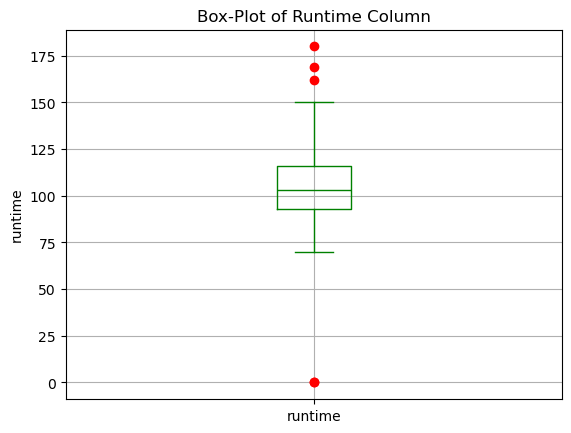

In [279]:
movies.boxplot('runtime', color='green',
               flierprops=dict(markeredgecolor='red',
                               markerfacecolor='red'))
plt.title('Box-Plot of Runtime Column')
plt.ylabel('runtime')
plt.show()

<center><b>Figure 1.</b> Box-Plot of Runtime Column</center>

Hence, given that the outliers are only 4 out of 128 and that they are relatively few, the team would push through with using the MinMaxScaler on the `runtime` column.

<h2 style="color: #5BC461">Data Exploration</h2>

In the dynamic and diverse world of cinema, Exploratory Data Analysis (EDA) serves as a crucial first step in understanding the underlying patterns and trends that shape the movie industry. Our analytical journey in 2023 begins with a thorough examination of the Rotten Tomatoes database, where each movie serves as a unique narrative entity contributing to the vast cinematic landscape. The EDA process in this context encompasses several key steps, each providing vital insights into different aspects of the movie data.

- <u>**Runtime Distribution Analysis**</u>: We delve into the exploration of movie runtimes, a critical aspect that often influences audience preferences and perceptions. This involves plotting the distribution of runtimes, providing insights into common lengths and deviations.

- <u>**Category Distribution Exploration**</u>: The analysis of movie categories unfolds the diversity in thematic content and narrative styles. This step includes a detailed look at the frequency and prevalence of various movie categories within our dataset.

- <u>**Genre Distribution Analysis**</u>: Finally, we analyze the distribution of movie genres, an aspect that reflects the creative and artistic choices in film-making. This analysis not only highlights popular genres but also uncovers less explored ones, revealing the breadth and depth of cinematic expression in 2023.

- <u>**Language Distribution Assessment**</u>: Movies are often defined by their language, an element that resonates cultural and regional nuances. We examine the distribution of movie languages, offering a glimpse into the linguistic diversity present in the 2023 movie lineup.

Through these EDA steps, we aim to build a comprehensive understanding of the movies released in 2023. This analysis not only aids in appreciating the current trends and preferences in the film industry but also sets the stage for more advanced analytical tasks, such as similarity assessments and predictive modeling, in our quest to explore the cinematic universe of 2023.

<h3>Runtime Distribution</h3>

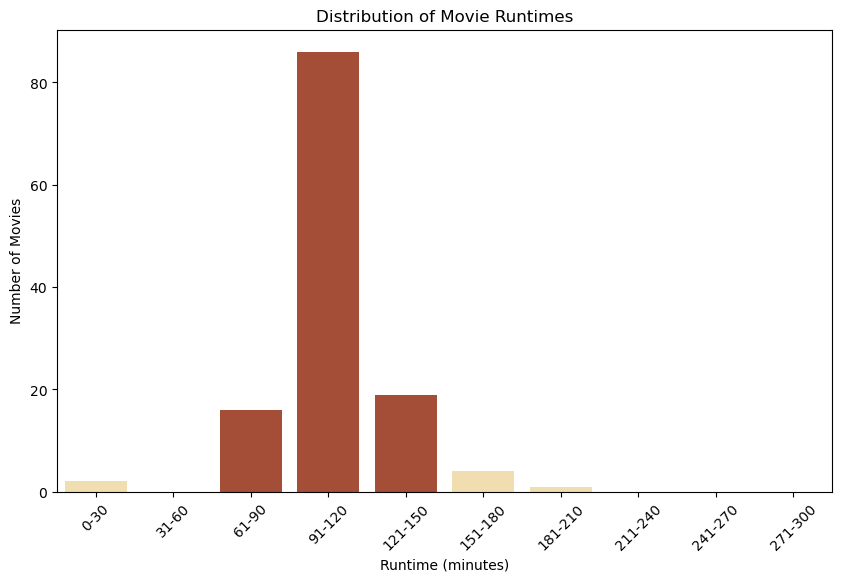

In [280]:
warnings.filterwarnings("ignore", category=FutureWarning)

df = movies

bin_ranges = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300]
bin_labels = ['0-30', '31-60', '61-90', '91-120', '121-150',
              '151-180', '181-210', '211-240', '241-270', '271-300']

df['runtime_bins'] = pd.cut(
    df['runtime'], bins=bin_ranges, labels=bin_labels, right=False)

runtime_counts = df['runtime_bins'].value_counts().sort_index()


top_colors = ['#B74325' if 1 < i < 5 else '#FAE3A6'
              for i in range(len(runtime_counts))]

plt.figure(figsize=(10, 6))
sns.barplot(x=runtime_counts.index, y=runtime_counts.values,
            palette=top_colors)

plt.xticks(rotation=45)
plt.xlabel('Runtime (minutes)')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Runtimes')

plt.show()

<center><b>Figure 2.</b> Distribution of Movie Runtimes</center>

#### The analysis of the runtime distribution highlights a clear inclination towards feature-length films of approximately **<u>1.5 to 2 hours**</u>, with a limited but notable acceptance of longer films up to about **2.5 hours**. **<u>Extremely short and very long films</u>** appear to be outliers, indicating their specialized roles within the broader landscape of the film industry.

- **Dominance of Standard Feature-Length Films**: A significant portion of the movies, particularly 86 out of the total, predominantly fall within the 91-120 minutes runtime range. This trend underscores a strong preference for standard feature-length films, which typically align with the audience's attention span and narrative development needs.

- **Niche Presence of Short and Extended Films**: The dataset reveals a minimal presence of extremely short (0-30 minutes, with only 2 films) and notably long films (151-180 minutes with 4 films, and 181-210 minutes with 1 film). This suggests that films deviating significantly from the standard duration are less common, catering to niche audiences or specific cinematic purposes.

- **Moderate Acceptance of Longer Narratives**: Films within the 121-150 minutes range, totaling 19, exhibit a moderate level of prevalence. This could reflect the industry's inclination towards more elaborate storytelling, potentially in genres that demand detailed plot development.

- **Absence of Ultra-Long Films**: The dataset shows no films exceeding 210 minutes, indicating the rarity of ultra-long cinematic experiences in mainstream cinema. Such lengths are likely reserved for unique or specialized film genres.

- **Clear Demarcation Between Film Categories**: The complete absence of films in the 31-60 minutes range points to a distinct separation between short films and feature-length films. This gap aligns with established industry norms and audience expectations regarding the categorization of film lengths.

<h3>Movie Category Analysis</h3>

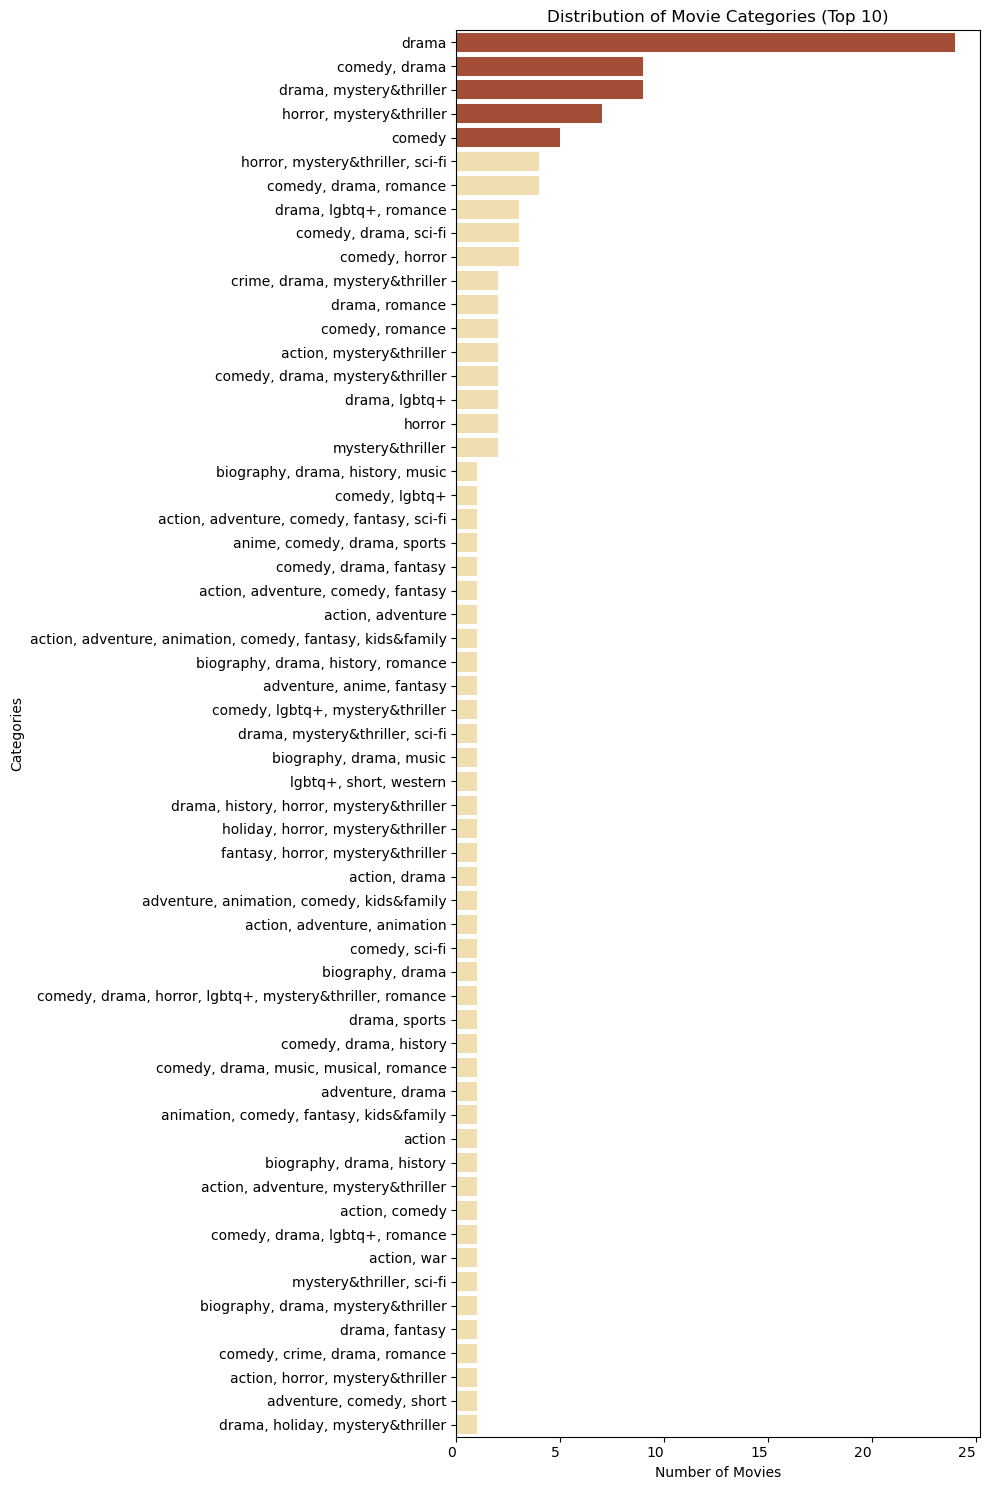

In [281]:
warnings.filterwarnings("ignore", category=FutureWarning)

cat = movies.loc[:, 'g_action':'g_western']
cat.columns = [re.sub(r'g_', '', i) for i in cat.columns]

lst_categories = []

for index, row in cat.iterrows():
    category = []
    for column in cat.columns:
        if row[column] == 1:
            category.append(column)
    categories = ', '.join(category)
    lst_categories.append(categories)

cat['categories'] = lst_categories

category_counts = cat['categories'].value_counts()

top_colors = ['#B74325' if i < 5 else '#FAE3A6'
              for i in range(len(category_counts))]

plt.figure(figsize=(10, 15))
sns.barplot(y=category_counts.index, x=category_counts.values,
            palette=top_colors, orient='h')

plt.xticks(rotation=0, ha='right')
plt.xlabel('Number of Movies')
plt.ylabel('Categories')
plt.title('Distribution of Movie Categories (Top 10)')

plt.tight_layout()
plt.show()

<center><b>Figure 3.</b> Distribution of Movie Categories</center>

#### The category distribution in the dataset demonstrates a rich tapestry of cinematic genres, with a strong inclination towards <u>**drama, hybrid genres, and suspenseful narratives**</u>. The presence of diverse genre combinations suggests an industry that is continually evolving and experimenting, aiming to cater to a wide array of audience preferences and tastes.

- **Predominance of Drama**: The single most prevalent category is 'drama,' with 24 films, highlighting its enduring appeal. Drama, known for its depth and emotional complexity, remains a cornerstone genre in the film industry.

- **Hybrid Genres Gaining Traction**: There is a notable presence of hybrid genres, such as 'drama, mystery&thriller' and 'comedy, drama', each with 9 films. This trend signifies a growing interest in films that blend elements from multiple genres, offering more nuanced and multifaceted cinematic experiences.

- **Horror and Mystery Fusion**: The combination of 'horror' with 'mystery&thriller' appears frequently, with 7 films falling into this combined category. Additionally, there are 4 films that blend 'horror, mystery&thriller, sci-fi', suggesting a strong audience interest in suspenseful and speculative narratives.

- **Diverse Combinations with Comedy**: 'Comedy' appears in various combinations, reflecting its versatility as a genre. It is seen paired with 'drama', 'horror', and even 'sci-fi', indicating a tendency to infuse humor into various narrative contexts.

- **LGBTQ+ Representation**: Films categorizing under 'drama, lgbtq+, romance' and similar combinations, although fewer in number, show an inclusion of LGBTQ+ themes in mainstream cinema. This represents a progressive move towards more diverse and representative storytelling.

- **Action and Mystery**: 'Action, mystery&thriller' is another popular combination, with 2 films. This blend suggests a continued audience interest in high-adrenaline, suspense-filled narratives.

- **Unique One-Off Combinations**: Several categories appear only once, such as 'biography, drama, history, music' and 'action, war'. These unique combinations indicate experimentation and niche filmmaking within the industry.

- **Animation and Family Films**: There is also a presence of 'animation' and 'kids&family' genres, sometimes combined with 'comedy' and 'adventure', highlighting the industry's focus on family-friendly entertainment.





<h3>Movie Genre Breakdown</h3>

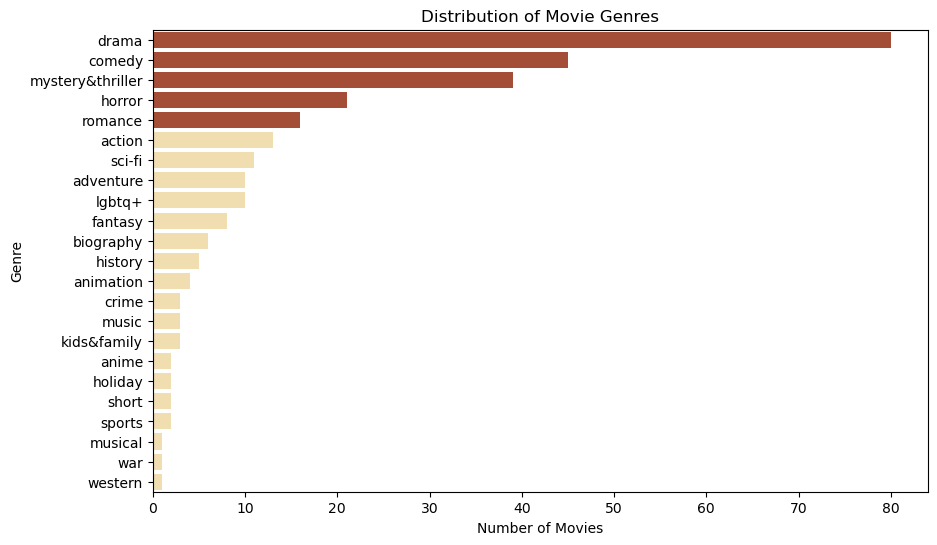

In [282]:
genres = movies.loc[:, 'g_action':'g_western']
genres.columns = [re.sub(r'g_', '', i) for i in genres.columns]

genres = genres.sum(axis=0)
genres = genres.sort_values(ascending=False)

top_colors = ['#B74325' if i < 5 else '#FAE3A6'
              for i in range(len(genres))]

plt.figure(figsize=(10, 6))
sns.barplot(y=genres.index, x=genres.values,
            palette=top_colors, orient="h")

plt.xticks(rotation=0)
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.title("Distribution of Movie Genres")

plt.show()

<center><b>Figure 4.</b> Distribution of Movie Genres</center>

#### The genre distribution in the dataset, where each genre is treated as a unique category without combinations, reflects a diverse cinematic palette, with drama and comedy at the forefront, followed by a strong interest in mystery, thriller, and horror. The presence of a wide array of other genres, though less frequent, underscores the industry's capacity to cater to varied and specific audience tastes and preferences.

- **Dominance of Drama**: With 80 films categorized under 'g_drama', this genre emerges as the most predominant. Drama's preeminence underscores its universal appeal and versatility in storytelling, capable of encompassing a wide range of human experiences and emotions.

- **Strong Presence of Comedy**: 'g_comedy', with 45 films, holds a significant position, reflecting the audience's consistent preference for humor and light-hearted entertainment. Comedy's ability to appeal to a broad audience base makes it a perennial favorite.

- **Popularity of Mystery and Thriller**: The 'g_mystery&thriller' genre, with 39 films, highlights the audience's inclination towards suspense, intrigue, and excitement. This genre's popularity suggests a strong demand for narratives that provide a sense of suspense and engagement.

- **Horror as a Staple Genre**: With 21 films, 'g_horror' maintains its status as a staple genre. The enduring appeal of horror speaks to the audience's fascination with fear, the supernatural, and the unknown.

- **Romance Continues to Charm**: 'g_romance', represented by 16 films, continues to charm audiences, showcasing the timeless appeal of love stories and romantic narratives.

- **Action and Sci-Fi**: 'g_action' and 'g_sci-fi' genres, with 13 and 11 films respectively, reflect the audience's interest in high-energy, visually impactful, and often technologically driven stories.

- **Adventure and Diversity**: 'g_adventure' and 'g_lgbtq+', each with 10 films, indicate a desire for escapism and exploration, as well as a growing recognition of diverse narratives within the mainstream.

- **Fantasy and Beyond**: 'g_fantasy', with 8 films, along with other genres like 'g_biography', 'g_history', and 'g_animation', each with a handful of films, suggest niche but dedicated audience interests in imaginative worlds, real-life stories, historical narratives, and animated features.

- **Lesser-Represented Genres**: Genres like 'g_crime', 'g_music', 'g_kids&family', and 'g_anime' appear less frequently, indicating more specialized audience segments. Similarly, 'g_holiday', 'g_short', 'g_sports', 'g_musical', 'g_war', and 'g_western', each with 1 or 2 films, represent highly niche categories within the cinematic landscape.

<h3>Movie Language Diversity</h3>

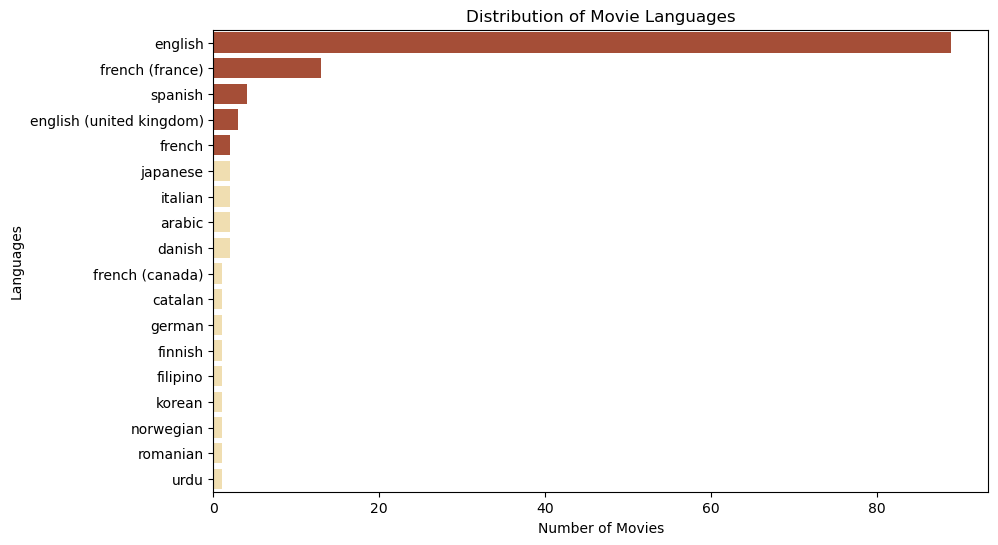

In [283]:
lang = movies.loc[:, 'lang_arabic':'lang_urdu']
lang.columns = [re.sub(r'lang_', '', i) for i in lang.columns]

lang = lang.sum(axis=0)
lang = lang.sort_values(ascending=False)

top_colors = ['#B74325' if i < 5 else '#FAE3A6'
              for i in range(len(lang))]

plt.figure(figsize=(10, 6))
sns.barplot(y=lang.index, x=lang.values,
            palette=top_colors, orient="h")

plt.xticks(rotation=0)
plt.xlabel("Number of Movies")
plt.ylabel("Languages")
plt.title("Distribution of Movie Languages")

plt.show()

<center><b>Figure 5.</b> Distribution of Movie Languages</center>

#### The language distribution analysis reveals a strong skew towards English, underscoring its predominant role in the global movie industry. However, the presence of a variety of other languages highlights the rich diversity and multicultural nature of contemporary cinema. This linguistic variety not only represents different cultural perspectives but also showcases the expansive reach and inclusive nature of the film industry, catering to a global audience with varied linguistic backgrounds.

- **Overwhelming Dominance of English**: With 89 films, 'English' is the overwhelmingly dominant language, underscoring the global influence and reach of English-language cinema. This prevalence reflects both the large English-speaking audience worldwide and the significant output of major film industries like Hollywood.

- **Significant Presence of French Cinema**: 'French (France)' ranks second with 13 films, indicating a strong representation of French cinema. This points to the cultural richness and global appeal of French-language films, known for their artistic and narrative depth.

- **Diversity in European and Asian Languages**: Languages like 'Spanish', 'Japanese', 'Italian', 'Arabic', and 'Danish', each with a few films, highlight the diversity of the dataset. These languages represent significant national cinemas that contribute richly to the global tapestry of film.

- **English Variants and Regional Films**: The presence of 'English (United Kingdom)' with 3 films and other regional variants like 'French (Canada)' with 1 film, illustrates the linguistic nuances and regional diversity within major languages.

- **Representation of Lesser-Known Languages**: Languages such as 'Korean', 'Catalan', 'Finnish', 'Romanian', 'Urdu', 'Filipino', 'Norwegian', and 'German', each with 1 film, though less prevalent, are indicative of the wide range of global cinema. Their inclusion reflects the industry's breadth and the increasing recognition of diverse linguistic narratives.

[Back to TOC](#TContents)

<a id='Method'></a>
<h1 style="color:#ffffff; background-color:#E44728; border: 1px solid #ffffff; padding: 10px 10px 10px 10px;">V. METHODOLOGY</h1>

<img src="methodology-v2.png">

<h2 style="color: #5BC461">Methodology Overview</h2>

<p>In creating the Information Retrieval System, the following were done:</p>
<p><b>Table 3.</b></p>
<p><i>Methodology Framework</i></p>
<table>
    <tr style="color:#ffffff; background-color:#E44728">
        <th style="text-align: left">Step No.</th>
        <th style="text-align: left">Step</th>
        <th style="text-align: left">Description</th>
    </tr>
    <tr>
        <td style="text-align: left">1.</td>
        <td style="text-align: left; font-weight: bold;">Data Extraction</td>
        <td style="text-align: left">The team scraped data from the Rotten Tomatoes' website and complied these data into a dataframe which was then saved into a database.</td>
    </tr>
    <tr>
        <td style="text-align: left">2.</td>
        <td style="text-align: left; font-weight: bold;">Data Preprocessing</td>
        <td style="text-align: left">The team preprocessed the data through one-hot encoding, stemming, common word-normalization, lowercasing of each character, and other relevant preprocessing techniques.</td>
    </tr>
    <tr>
        <td style="text-align: left">3.</td>
        <td style="text-align: left; font-weight: bold;">Information Retrieval Creation</td>
        <td style="text-align: left">The team tested several distance measures for the system, where the distance measure which would provide the highest IR metric would be used as the final measure.</td>
    </tr>
    <tr>
        <td style="text-align: left">4.</td>
        <td style="text-align: left; font-weight: bold;">Evaluation of IR System</td>
        <td style="text-align: left">The team evaluated the created IR systems using average (precision @ k), average (recall @k), mean average precision, area under the Averaged Eleven-Point PR curve, and such which would then be discussed afterwards.</td>
    </tr>
</table>

<h2 style="color: #5BC461">Data Extraction</h2>

With web scraping, Requests, and BeautifulSoup consolidated in the function `get_all_movie_info`, the team was able to extract movie details from the Rotten Tomatoes movie pages.

As said beforehand, the categorical columns, genre and language, were one-hot encoded. This preprocessing is done for easier conversion to SQLite table. In the end, the team have all the details for each movie, detailed in Table 1.
   
These collected data was placed in a dataframe, and then turned into an SQLite database for exploration and processing through the function `movie_sql`.

<h2 style="color: #5BC461">Data Preprocessing</h2>

As said beforehand, the table `movies_encoded` from the `rotten_tomatoes.db` is loaded using the function `load_sql`. A preview is shown in Table 2.

In [284]:
%%capture
movies = load_sql()

In pre-processing the data, given that there are columns which are essentially documents or "collection" of strings which are `synopsis` and `critic`, these columns would be converted into bag-of-words through the function `bag_of_words`. In doing so, a fitted vectorizer would also be made available. To test the difference in performance between default parameters and "optimally" set parameters, the team would be making two dataframes named `movie_default` and `movie_optimal`.

In setting the parameters for `movie_optimal`, a preprocesser function named `preprocesser` was defined, wherein it places all the documents into lowercase, removes special characters, normalizes certain common words such as `in`, `the`, and the like, and stems the words through the English Snowball stemmer. The rationale for stemming the words is to allow the Information Retrieval System to "recognize" words which are diffent in spelling yet similar in meaning; these includes conjugated words such as `explored` and `exploring`. Furthermore, an ngram_range of (1,2) was set in order to capture meaningful two-word phrases which may help in finding similar movies or differentiating them from one another.

Moreover, common stop words acquired from Ganesan (n.d.) were used as stop words, and these include common words such as `another`, `certain`, and such. This is to remove noise from the system and to avoid associating dissimilar movies, by virtue of their similarities in numbers of these stop words. Lastly, to make sure that extremely rare and extremely common words are removed from the system, a max_df of 0.9 is set and a min_df of 0.1 is set as well. This would remove words which are present in more than 90% and in less than 10% of the documents.

In [285]:
warnings.filterwarnings('ignore')

# Movies (Default Mode)
vectorizer_default_synopsis, movie_default_synopsis = bag_of_words(
    movies['synopsis'], mode='default')
movie_default_synopsis = pd.DataFrame.sparse.from_spmatrix(
    movie_default_synopsis,
    columns=vectorizer_default_synopsis.get_feature_names_out(),
)
vectorizer_default_critic, movie_default_critic = bag_of_words(
    movies['critic'], mode='default')
movie_default_critic = pd.DataFrame.sparse.from_spmatrix(
    movie_default_critic,
    columns=vectorizer_default_critic.get_feature_names_out(),
)

# Movies (Optimal Mode)
vectorizer_optimal_synopsis, movie_optimal_synopsis = bag_of_words(
    movies['synopsis'], mode='optimal')
movie_optimal_synopsis = pd.DataFrame.sparse.from_spmatrix(
    movie_optimal_synopsis,
    columns=vectorizer_optimal_synopsis.get_feature_names_out(),
)
vectorizer_optimal_critic, movie_optimal_critic = bag_of_words(
    movies['critic'], mode='optimal')
movie_optimal_critic = pd.DataFrame.sparse.from_spmatrix(
    movie_optimal_critic,
    columns=vectorizer_optimal_critic.get_feature_names_out(),
)

The following are a preview of each table.

<p><b>Table 4.</b></p>
<p><i>Movies Synopsis (Default Settings)</i></p>

In [286]:
movie_default_synopsis.head(3)

,11,12,12th,15,16,17,18th,1945,1960s,1976,...,younger,youngest,your,yourself,youssef,youth,zadi,zakhar,zem,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<p><b>Table 5.</b></p>
<p><i>Movies Critic (Default Settings)</i></p>

In [287]:
movie_default_critic.head(3)

,00s,10,104,10s,16mm,18th,1970,1980s,1992,1998,...,zaniness,zany,zee,zero,zion,zip,zlotowski,zone,zoom,zootropolis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


<p><b>Table 6.</b></p>
<p><i>Movies Synopsis (Optimal Settings)</i></p>

In [288]:
movie_optimal_synopsis.head(3)

,_connector_ world,are,back,be,becom,begin,best,can,discov,famili,...,them,they,time,two,when,who,world,year,year old,young
0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


<p><b>Table 7.</b></p>
<p><i>Movies Critic (Optimal Settings)</i></p>

In [289]:
movie_optimal_critic.head(3)

,_connector_ _connector_,_connector_ end,_connector_ film,_connector_ it,_connector_ most,_connector_ movi,_connector_ spanish,_connector_ way,action,actor,...,which,while,who,will,work,world,writer,year,you,your
0,0,0,0,0,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


To further optimize Table 5, the IDFs of the vectorized `critic` and `synopsis` would be calculated, and from this, the tokens with the lowest IDFs would be removed, as these tokens would serve as the "domain-specific" common words, wherein the domain in this study would be on films.

In [290]:
# Synopsis Optimal
vectorizer_optimal_synopsis, movie_optimal_synopsis = bag_of_words(
    movies['synopsis'], mode='optimal')
idf_movie_synopsis = sort_idf(movie_optimal_synopsis,
                             vectorizer_optimal_synopsis)

# Critic Optimal
vectorizer_optimal_critic, movie_optimal_critic = bag_of_words(
    movies['critic'], mode='optimal')
idf_movie_critic = sort_idf(movie_optimal_critic,
                             vectorizer_optimal_critic)

The following are the tables showing the top 5 words with the least IDFs. What would be done then with the "domain-specific" common words which are at the range from 1 to 2 (exclusive) within this top 5 list would be to remove them as they serve as noise and do not help in differentiating the movies at all.

<p><b>Table 8.</b></p>
<p><i>Movies_Optimal Synopsis IDFs</i></p>

In [291]:
idf_movie_synopsis.head(5)

,idf_weights
is,1.655120
when,1.889520
who,2.276293
she,2.276293
life,2.394077


<p><b>Table 9.</b></p>
<p><i>Movies_Optimal Critic IDFs</i></p>

In [292]:
idf_movie_critic.head(5)

,idf_weights
film,1.244692
movi,1.625706
be,1.732678
what,1.834461
more,1.834461


Having seen that there are tokens which have very low IDFs, using the same "optimal" parameters, both columns `synopsis` and `critic` would be converted to the bag-of-words again, but preprocessed with the new "domain-specific" stop words, alongside the original set of stop words.

In [293]:
# Optimal Synopsis
vectorizer_optimal_synopsis, movie_optimal_synopsis = bag_of_words(
    movies['synopsis'],
    mode='optimal',
    stop_extend=list(idf_movie_synopsis.head(2).index)
)
movie_optimal_synopsis = pd.DataFrame.sparse.from_spmatrix(
    movie_optimal_synopsis,
    columns=vectorizer_optimal_synopsis.get_feature_names_out(),
)

# Optimal Critic
vectorizer_optimal_critic, movie_optimal_critic = bag_of_words(
    movies['critic'],
    mode='optimal',
    stop_extend=list(idf_movie_critic.head(5).index)
)
movie_optimal_critic = pd.DataFrame.sparse.from_spmatrix(
    movie_optimal_critic,
    columns=vectorizer_optimal_critic.get_feature_names_out(),
)

<p><b>Table 10.</b></p>
<p><i>Movies Synopsis (Optimal Settings; Additional Stop)</i></p>

In [294]:
movie_optimal_synopsis.head(3)

,_connector_ world,are,back,be,becom,begin,best,can,discov,famili,...,take,them,they,time,two,who,world,year,year old,young
0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


<p><b>Table 11.</b></p>
<p><i>Movies Critic (Optimal Settings; Additional Stop)</i></p>

In [295]:
movie_optimal_critic.head(3)

,_connector_ _connector_,_connector_ end,_connector_ is,_connector_ it,_connector_ most,_connector_ spanish,_connector_ way,action,actor,also,...,which,while,who,will,work,world,writer,year,you,your
0,0,0,0,0,0,1,0,0,1,1,...,0,1,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The four tables (default and optimal) would then be normalized as TFIDF values. This would be done through the function `normalize_tfidf`.

In [296]:
# Movies (Default Mode)
vectorizer_default_synopsis, movie_default_synopsis = bag_of_words(
    movies['synopsis'], mode='default')
vectorizer_default_critic, movie_default_critic = bag_of_words(
    movies['critic'], mode='default')
vectorizer_def_sys_tfidf, movie_default_synopsis = normalize_tfidf(
    movie_default_synopsis)
vectorizer_def_crit_tfidf, movie_default_critic = normalize_tfidf(
    movie_default_critic)
movie_default_synopsis = pd.DataFrame.sparse.from_spmatrix(
    movie_default_synopsis,
    columns=vectorizer_default_synopsis.get_feature_names_out(),
)
movie_default_critic = pd.DataFrame.sparse.from_spmatrix(
    movie_default_critic,
    columns=vectorizer_default_critic.get_feature_names_out(),
)

# Movies (Optimal Mode)
vectorizer_optimal_synopsis, movie_optimal_synopsis = bag_of_words(
    movies['synopsis'],
    mode='optimal',
    stop_extend=list(idf_movie_synopsis.head(2).index)
)
vectorizer_optimal_critic, movie_optimal_critic = bag_of_words(
    movies['critic'],
    mode='optimal',
    stop_extend=list(idf_movie_critic.head(5).index)
)
vectorizer_opt_sys_tfidf, movie_optimal_synopsis = normalize_tfidf(
    movie_optimal_synopsis)
vectorizer_opt_crit_tfidf, movie_optimal_critic = normalize_tfidf(
    movie_optimal_critic)
movie_optimal_synopsis = pd.DataFrame.sparse.from_spmatrix(
    movie_optimal_synopsis,
    columns=vectorizer_optimal_synopsis.get_feature_names_out(),
)
movie_optimal_critic = pd.DataFrame.sparse.from_spmatrix(
    movie_optimal_critic,
    columns=vectorizer_optimal_critic.get_feature_names_out(),
)

The four tables are previewed below:

<p><b>Table 12.</b></p>
<p><i>Movies Synopsis (Default Settings; TFIDF Normalized)</i></p>

In [297]:
movie_default_synopsis.head(5)

,11,12,12th,15,16,17,18th,1945,1960s,1976,...,younger,youngest,your,yourself,youssef,youth,zadi,zakhar,zem,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<p><b>Table 13.</b></p>
<p><i>Movies Critic (Default Settings; TFIDF Normalized)</i></p>

In [298]:
movie_default_critic.head(5)

,00s,10,104,10s,16mm,18th,1970,1980s,1992,1998,...,zaniness,zany,zee,zero,zion,zip,zlotowski,zone,zoom,zootropolis
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.127834,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


<p><b>Table 14.</b></p>
<p><i>Movies Synopsis (Optimal Settings; TFIDF Normalized)</i></p>

In [299]:
movie_optimal_synopsis.head(5)

,_connector_ world,are,back,be,becom,begin,best,can,discov,famili,...,take,them,they,time,two,who,world,year,year old,young
0,0.0,0.301699,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.301699,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.289036,0.000000,0.306247
1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.243383,0.0,0.266502,0.323606,0.000000
2,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.340635,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
3,0.0,0.000000,0.245681,0.440677,0.0,0.240856,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.181147,0.0,0.000000,0.000000,0.210165
4,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000


<p><b>Table 15.</b></p>
<p><i>Movies Critic (Optimal Settings; TFIDF Normalized)</i></p>

In [300]:
movie_optimal_critic.head(5)

,_connector_ _connector_,_connector_ end,_connector_ is,_connector_ it,_connector_ most,_connector_ spanish,_connector_ way,action,actor,also,...,which,while,who,will,work,world,writer,year,you,your
0,0.0,0.0,0.000000,0.0,0.000000,0.189491,0.0,0.0,0.197687,0.167216,...,0.000000,0.175795,0.000000,0.0,0.146946,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.151074,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.190172,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.145567,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.0,0.161545,0.154848,0.0,0.0,0.161545,0.000000,...,0.132463,0.000000,0.125019,0.0,0.000000,0.0,0.0,0.0,0.095729,0.0


These default and optimal dataframes are then concatenated separately to the main dataframe `movies`, resulting to two dataframes `movies_default` and `movies_optimal`. As the next step is normalization of the column `runtime`, given that `runtime` is a buzzword in the film domain and it was seen that there is indeed a token named `runtime` in the bag-of-word dataframes, the original `runtime` column name would be changed to `runtime_old`. Moreover, given that `title` would be used and there is a duplicate column because of the bag-of-word step, the column name for `title` is changed to `title_old`.

In [301]:
concat_movies = movies.rename(columns={'runtime': 'runtime_old',
                                       'title': 'title_old'})

# Movies (Default)
movies_default = concat_movies.drop(['critic', 'synopsis'], axis=1)
movies_default = pd.concat([movies_default, movie_default_synopsis,
                            movie_default_critic], axis=1)

# Movies (Optimal)
movies_optimal = concat_movies.drop(['critic', 'synopsis'], axis=1)
movies_optimal = pd.concat([movies_optimal, movie_optimal_synopsis,
                            movie_optimal_critic], axis=1)

Lastly, the column `runtime` in both dataframes will be scaled with MinMaxScaler in order to scale the values in this column to the range from zero to one, the range in the one-hot encoded columns and in the TFIDF normalized columns.

In [302]:
scaler_default = MinMaxScaler()
scaler_optimal = MinMaxScaler()


# Movies (Default)
runtime_default = scaler_default.fit_transform(
    movies_default[['runtime_old']])
runtime_default = pd.DataFrame(runtime_default, columns=['runtime_old'])
movies_default.drop('runtime_old', axis=1, inplace=True)
movies_default = pd.concat([movies_default, runtime_default], axis=1)

# Movies (Optimal)
runtime_optimal = scaler_optimal.fit_transform(
    movies_optimal[['runtime_old']])
runtime_optimal = pd.DataFrame(runtime_optimal, columns=['runtime_old'])
movies_optimal.drop('runtime_old', axis=1, inplace=True)
movies_optimal = pd.concat([movies_optimal, runtime_optimal], axis=1)

The final tables which would be used in the Information Retrieval part are presented below:

<p><b>Table 16.</b></p>
<p><i>Movies Default (Final)</i></p>

In [303]:
movies_default.head(3)

,title_old,g_action,g_adventure,g_animation,g_anime,g_biography,g_comedy,g_crime,g_drama,g_fantasy,...,zany,zee,zero,zion,zip,zlotowski,zone,zoom,zootropolis,runtime_old
0,Afire,0,0,0,0,0,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.572222
1,A Thousand and One,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.650000
2,A Million Miles Away,0,0,0,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.127834,0.0,0.672222


<p><b>Table 17.</b></p>
<p><i>Movies Optimal (Final)</i></p>

In [304]:
movies_optimal.head(3)

,title_old,g_action,g_adventure,g_animation,g_anime,g_biography,g_comedy,g_crime,g_drama,g_fantasy,...,while,who,will,work,world,writer,year,you,your,runtime_old
0,Afire,0,0,0,0,0,1,0,1,0,...,0.175795,0.000000,0.0,0.146946,0.0,0.0,0.0,0.0,0.0,0.572222
1,A Thousand and One,0,0,0,0,0,0,0,1,0,...,0.000000,0.151074,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.650000
2,A Million Miles Away,0,0,0,0,1,0,0,1,0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.672222


<h2 style="color: #5BC461">Information Retrieval Creation</h2>

<p>For the information retrieval system, the following distance metrics would be used:</p>
<ul>
    <li>Euclidian Distance (l2 norm)</li>
    <li>Manhattan Distance (l1 norm)</li>
    <li>Cosine Distance</li>
</ul>

In order to get all the distance matrices for both dataframes, the function `nearest_k` would be used. The results from each call would then be used for the evaluation part.

<h2 style="color: #5BC461">Evaluation of IR System</h2>

In evaluating the IR System, the following genres from Rotten Tomatoes and their corresponding movies were used as the queries. This is in order to approximate a representation of querying each type of movie in evaluating the performance of the IR system.

<p><b>Table 18.</b></p>
<p><i>Genres and Corresponding Movies (Evaluation)</i></p>
<table>
    <tr style="color:#ffffff; background-color:#E44728">
        <th style="text-align: left">No.</th>
        <th style="text-align: left">Genre</th>
        <th style="text-align: left">Movie</th>
    </tr>
    <tr>
        <td style="text-align: left">1.</td>
        <td style="text-align: left; font-weight: bold;">Drama</td>
        <td style="text-align: left">Oppenheimer</td>
    </tr>
    <tr>
        <td style="text-align: left">2.</td>
        <td style="text-align: left; font-weight: bold;">Comedy</td>
        <td style="text-align: left">Sitting in Bars with Cake</td>
    </tr>
    <tr>
        <td style="text-align: left">3.</td>
        <td style="text-align: left; font-weight: bold;">Mystery and Thriller</td>
        <td style="text-align: left">M3GAN</td>
    </tr>
    <tr>
        <td style="text-align: left">4.</td>
        <td style="text-align: left; font-weight: bold;">Horror</td>
        <td style="text-align: left">The Blackening</td>
    </tr>
    <tr>
        <td style="text-align: left">5.</td>
        <td style="text-align: left; font-weight: bold;">Romance</td>
        <td style="text-align: left">Red, White & Royal Blue</td>
    </tr>
    <tr>
        <td style="text-align: left">6.</td>
        <td style="text-align: left; font-weight: bold;">Action</td>
        <td style="text-align: left">John Wick: Chapter 4</td>
    </tr>
    <tr>
        <td style="text-align: left">7.</td>
        <td style="text-align: left; font-weight: bold;">Sci-Fi</td>
        <td style="text-align: left">Biosphere</td>
    </tr>
    <tr>
        <td style="text-align: left">8.</td>
        <td style="text-align: left; font-weight: bold;">Adventure</td>
        <td style="text-align: left">Guardians of the Galaxy Vol. 3</td>
    </tr>
    <tr>
        <td style="text-align: left">9.</td>
        <td style="text-align: left; font-weight: bold;">LGBTQA+</td>
        <td style="text-align: left">Shortcomings</td>
    </tr>
    <tr>
        <td style="text-align: left">10.</td>
        <td style="text-align: left; font-weight: bold;">Fantasy</td>
        <td style="text-align: left">Suzume</td>
    </tr>
</table>

As a preface for the validation data or gold standard, the team assumed the roles of domain experts in validating whether a film is relevant to a given film or not. <b>The relevant films were determined by comparing the genre, summary, and trailers of one film vs. the other, where similar genres and storyline are determined relevant to each other.</b> Moreover, instead of having only one team member validate the relevance of a film to another, another team member also did their own validation. In the case of conflict between the judgment of one team member over the other, one team member served as arbiter in deciding whether the said film is indeed relevant or not. This validation data or gold standard, which is opened as a dataframe, is cleaned minimally, wherein null values are turned to into zeroes, twos (indicating relevance) or hundreds (indicating exact similarity to the film in question) are changed to ones, and the dtype is changed to int. Moreover, given a difference in the order of the titles, the titles were sorted in accordance with the order in the original `movies` dataframe.

<p><b>Table 19.</b></p>
<p><i>Preview of Validation Data</i></p>

In [305]:
validation_data = pd.read_csv('validation_data.csv')
validation_data.fillna(0, inplace=True)
validation_data_temp = validation_data.iloc[:, 1:].astype(int)
validation_data = pd.concat([validation_data.iloc[:, 0],
                             validation_data_temp],
                             axis=1)
validation_data = validation_data.map(
    lambda x: 1 if x == 2 or x == 100 else x)
movies.set_index('title', inplace=True)
validation_data.set_index('title', inplace=True)
validation_data = validation_data.reindex(movies.index)
movies.reset_index(inplace=True)
validation_data.reset_index(inplace=True)
validation_data.head(3)

,title,Oppenheimer,Sitting in Bars with Cake,M3GAN,The Blackening,"Red, White & Royal Blue",John Wick: Chapter 4,Biosphere,Guardians of the Galaxy Vol. 3,Shortcomings,Suzume
0,Afire,0,1,0,0,1,0,0,0,0,0
1,A Thousand and One,0,0,0,0,0,0,0,0,0,0
2,A Million Miles Away,1,0,0,0,0,0,0,0,0,0


The kappa statistic, a measure of how much the judges agree on relevance, whether they agree all of the time, most of the time, by chance or by "worse than random" (possibly hinting a negative bias), would be calculated for all combinations of the three judges to provide a tight rationale on why the created gold standard should be used (Cambridge UP, 2008). 

The method for acquiring the kappa statistic is as follows (Cambridge UP, 2008):

The $P(A)$ or the observed proportion of the times the judges agreed would be first calculated and this is calculated by:

$$P(A) = P(Yes \space and \space Yes) + P(No \space and \space No)$$

Second, the pooled marginals are acquired and calculated as follows:

$$P(nonrelevant) = \frac{Total \space No \space Votes}{Total \space Votes}$$

$$P(relevant) = \frac{Total \space Yes \space Votes}{Total \space Votes}$$

Using these pooled marginals, $P(E)$ or the probability that the judges agreed by chance is calculated where it is defined as:

$$P(E) = P(nonrelevant)^{2} + P(relevant)^{2}$$

Lastly, the kappa statistic is calculated using these values:

$$\kappa = \frac{(P(A) - P(E))}{(1- P(E))}$$

Shown below are the relevance matrix for each pair of judge and a table containing all their kappa statistics and the average pairwise kappa statistic, created from the Data Frames from the csv files for each judge (`judge_1.csv`, `judge_2.csv`, and `validation_data.csv`) using the function `kappa` where alongside the calculation, null values are changed to zeroes and non-null values are changed to ones. Moreover, the `title` columns in all data frames are removed. The average pairwise kappa statistic is then calculated and evaluated to show whether the gold standard is reliable or not.

<p><b>Table 20.</b></p>
<p><i>Relevance Matrix (Judge 1 vs. Judge 2)</i></p>

In [306]:
judge_1 = pd.read_csv('judge_1.csv')
judge_1.drop('title', axis=1)
judge_2 = pd.read_csv('judge_2.csv')
judge_2.drop('title', axis=1)
judge_3 = pd.read_csv('validation_data.csv')
judge_3.drop('title', axis=1)

kappa_12, rel_mat12 = kappa(judge_1, judge_2, 'Judge 1', 'Judge 2')
rel_mat12

Judge 2            
                  Yes    No Total
Judge 1 Yes       151    27   178
        No         45  1185  1230
        Total     196  1212  1408

<p><b>Table 21.</b></p>
<p><i>Relevance Matrix (Judge 2 vs. Judge 3)</i></p>

In [307]:
kappa_23, rel_mat23 = kappa(judge_2, judge_3, 'Judge 2', 'Judge 3')
rel_mat23

Judge 3            
                  Yes    No Total
Judge 2 Yes       166    30   196
        No         11  1201  1212
        Total     177  1231  1408

<p><b>Table 22.</b></p>
<p><i>Relevance Matrix (Judge 1 vs. Judge 3)</i></p>

In [308]:
kappa_13, rel_mat13 = kappa(judge_1, judge_3, 'Judge 1', 'Judge 3')
rel_mat13

Judge 3            
                  Yes    No Total
Judge 1 Yes       162    16   178
        No         15  1215  1230
        Total     177  1231  1408

<p><b>Table 23.</b></p>
<p><i>Kappa Statistics</i></p>

In [309]:
pd.DataFrame(
    {
        "Judge 1 vs. 2": "{:0.2f}".format(kappa_12),
        "Judge 2 vs. 3": "{:0.2f}".format(kappa_23),
        "Judge 1 vs. 3": "{:0.2f}".format(kappa_13),
        "Average Pairwise": "{:0.2f}".format(np.mean([kappa_12, kappa_23,
                                                      kappa_13])),
    },
    index=["Kappa Statistics"],
)

,Judge 1 vs. 2,Judge 2 vs. 3,Judge 1 vs. 3,Average Pairwise
Kappa Statistics,0.78,0.87,0.90,0.85


Given that Cambridge UP (2008) states that values above 0.8 is taken as "good agreement", values between 0.67 and 0.8 is taken as "fair agreement", and values below 0.67 would consider the created standard as a dubious basis for the evaluation and given that the calculated average pairwise kappa statistic would be considered as "good agreement", the created gold standard is thus reliable. As a side note, despite Judge 1 and Judge 2 having a "fair agreement" in their own sets of evaluation, this relatively lower yet sufficient kappa statistic was raised by the arbitrations of the third judge, turning it into a "good agreement".

Moving on, in evaluating the two variants of the Information Retrieval System, several metrics would be used, and to guide the parameters (i.e., k) for some metrics, a Precision-Recall vs. k graph would be first plotted with the help of functions such as `pk`, and `rk`, and using the insights from these graph, the parameters would then be set. The important evaluation metrics are:

<p><b>Table 24.</b></p>
<p><i>Evaluation Metrics</i></p>

<table>
    <tr style="color:#ffffff; background-color:#E44728">
        <th style="text-align: left">No.</th>
        <th style="text-align: left">Evaluation Metric</th>
        <th style="text-align: left">Description</th>
    </tr>
    <tr>
        <td style="text-align: left">1.</td>
        <td style="text-align: left; font-weight: bold;">Average<br> (Precision @ k)</td>
        <td style="text-align: left">In this metric, at an arbitrarily set k results based on the Precision-Recall vs. k graph, the precision would be calculated per query then averaged again. This is a good metric to measure in this type of IR given that most users of a recommender system would only appreciate seeing few movies to watch (e.g. 5) than several ones. Moreover, given the relatively small dataset, having high number of results than the supposed number of relevant movies to return would distort the performance of the IR system to be worse than it should be.</td>
    </tr>
    <tr>
        <td style="text-align: left">2.</td>
        <td style="text-align: left; font-weight: bold;">Average<br> (Recall @ k)</td>
        <td style="text-align: left">In this metric, at an arbitrarily set k based on the Precision-Recall vs. k graph, the recall would be calculated per query then averaged again.</td>
    </tr>
    <tr>
        <td style="text-align: left">3.</td>
        <td style="text-align: left; font-weight: bold;">Average<br> (F-1 Score @ k and beta = 0.5)</td>
        <td style="text-align: left">After getting both Average (Precision @ k) and Average (Recall @ k), the F-1 score is calculated using the same metrics, with more emphasis on precision over recall. There is more emphasis on precision (beta = 0.5) over recall given that avoiding false positives is more important than avoiding false negatives, given that a user of this recommendation system would not feel satisfied if the returned "relevant" results are in fact actually irrelevant. Compare this to a scenario where the same user would miss relevant results; being recommended an irrelevant movie would have more consequences to user satisfaction as compared to missing an opportunity to be recommended a relevant movie.</td>
    </tr>
    <tr>
        <td style="text-align: left">4.</td>
        <td style="text-align: left; font-weight: bold;">Mean Average Precision (MAP)</td>
        <td style="text-align: left">For every query, this metric considers up to the final relevant result or kth result, through which the metric computes the average precision @ k for the given query. As compared to Average (Precision @ k) which only considers the precision at exactly k, in this metric, all ks with a corresponding relevant results are considered in the average, while ks with corresponding irrelevant results are disregarded. The arithmetic mean of all these averages are then calculated. Being a robust metric, it provides equal weight to each query, and thus serves as a more reliable metric for precision than Average (Precision @ k).</td>
    </tr>
    <tr>
        <td style="text-align: left">5.</td>
        <td style="text-align: left; font-weight: bold;">Average<br> R-Precision</td>
        <td style="text-align: left">This metric takes into account how many truly relevant movies (where its number is denoted by |Rel|) are there for a given movie query and takes this into account for each query where the precision for each query is simply the Average (Precision @ |Rel|). These are averaged, and this can serve as both the average precision and recall for the IR system. As a side note, the unaveraged measure would also be retrieved for each genre, to gather insights on the IR and its possible relationships to the population or distribution or characteristics of its dataset.</td>
    </tr>
    <tr>
        <td style="text-align: left">6.</td>
        <td style="text-align: left; font-weight: bold;">Averaged 11-point Precision/Recall Curve</td>
        <td style="text-align: left">The interpolated precision (possible highest precision) at recall levels ranging from 0 to 1 (with an increment of 0.1) are calculated for each query, and these averaged interpolated precisions are then plotted, where the goal is to highlight potential or possible increases in precision given an increase in the result set (Cambridge UP, 2009). This was also done in order to consolidate all query results into one Precision/Recall Curve.</td>
    </tr>
</table>

For each variant and corresponding distance measure, all of these evaluation metrics would be calculated. These are through functions such as `pk` and `a_pk` for the Average (Precision @ k), `rk` and `a_rk` for the Average (Recall @ k), `mapk` for Mean Average Precision (MAP), `mf_onek` for Average (F-1 Score @ k), `rprec` and `ave_rprec` for either (unaveraged) R-Precisions per genre or Average R-Precision, and `ave_prg` for acquring the interpolated values in plotting the Averaged 11-point Precision/Recall Curve.

To further expound on each evaluation metric, these are their formulas:

<b>1. Average (Precision @ k)</b>
$$P_{ave, k} = \frac{\displaystyle{\sum^{N}_{i=1}}\frac{TP_{k, i}}{(TP+FP)_{k, i}}}{\textit{N}}$$

where $TP_{k,i}$ is equal to the number of true positives at k for query $i$, $(TP+FP)_{k,i}$ is equal to the number of true and false positives at k for query $i$, and $N$ is equal to the number of queries.

<b>2. Average (Recall @ k)</b>
$$R_{ave, k} = \frac{\displaystyle{\sum^{n}_{i=1}}\frac{TP_{k, i}}{(TP+FN)_{k, i}}}{\textit{N}}$$

where $TP_{k,i}$ is equal to the number of true positives at k for query $i$, $(TP+FN)_{k,i}$ is equal to the number of true and false positives at k for query $i$, and $N$ is equal to the number of queries.

<b>3. Average (F-1 Score @ k)</b>
$$F_{\beta, ave, k} = (1 + \beta^2) \cdot \frac{P_{ave, k} \cdot R_{ave, k}}{(\beta^2 \cdot P_{ave, k}) + R_{ave, k}}$$

where $P_{ave, k}$ is the average (precision @ k), $R_{ave, k}$ is the average (recall @ k), and $\beta$ is the ratio of recall importance to precision importance.

<b>4. Mean Average Precision</b>
$$MAP = \frac{1}{N} \displaystyle{\sum^{N}_{j=1}} \frac{1}{Q_j} \displaystyle{\sum^{Q_{j}}_{i=1}} P(doc_{i})$$

where $Q_j$ is the number of relevant documents for query j, $N$ is the number of queries, and $P(doc_{i})$ is the precision at ith relevant document (University of Cambridge Computer Laboratory).

<b>5. Average R-Precision</b>
$$(R-Precision)_{ave} = \frac{1}{N} \displaystyle{\sum^{N}_{i=1}}\frac{r_{i}}{|Rel|_{i}}$$

where $r_i$ is the returned relevant documents for query $i$ while $|Rel|_i$ is the number of relevant documents in the corpus for query $i$. For the part where each query is evaluated, the $\frac{1}{N}$ is removed in order to acquire the R-Precision for each query (or genre) (Cambridge UP, 2009).

<b>6. Interpolated Precision for Averaged 11-point Precision/Recall Curve</b>
$$\rho_{interp}(r) = \underset{r'\ge r}{max}\space \rho(r')$$

where $\rho_{interp}(r)$ is the interpolated precision at a certain recall level $r$ and where the interpolated precision for each of the eleven points is acquired by getting the first highest precision from r values lower than the current r value (Cambridge UP, 2009).

[Back to TOC](#TContents)

<a id='Results'></a>
<h1 style="color:#ffffff; background-color:#E44728; border: 1px solid #ffffff; padding: 10px 10px 10px 10px;">VI. RESULTS AND DISCUSSION</h1>

In [310]:
# Preparing dictionaries
l2_dict = {'Default': {}, 'Optimal': {}}
l1_dict = {'Default': {}, 'Optimal': {}}
cos_dict = {'Default': {}, 'Optimal': {}}

for column in validation_data.columns[1:]:
    # Euclidian Distance
    query_d = movies_default[movies_default['title_old'] == column].iloc[0]
    query_d = query_d.drop('title_old')
    query_o = movies_optimal[movies_optimal['title_old'] == column].iloc[0]
    query_o = query_o.drop('title_old')
    l2_default = nearest_k(query_d,
                           movies_default.iloc[:, 1:].to_numpy(),
                           len(movies_default),
                           euclidean)
    l2_optimal = nearest_k(query_o,
                           movies_optimal.iloc[:, 1:].to_numpy(),
                           len(movies_optimal),
                           euclidean)
    l2_dict['Default'][column] = l2_default
    l2_dict['Optimal'][column] = l2_optimal

    # Manhattan Distance
    l1_default = nearest_k(query_d,
                           movies_default.iloc[:, 1:].to_numpy(),
                           len(movies_default),
                           cityblock)
    l1_optimal = nearest_k(query_o,
                           movies_optimal.iloc[:, 1:].to_numpy(),
                           len(movies_optimal),
                           cityblock)
    l1_dict['Default'][column] = l1_default
    l1_dict['Optimal'][column] = l1_optimal

    # Cosine Distance
    cos_default = nearest_k(query_d,
                            movies_default.iloc[:, 1:].to_numpy(),
                            len(movies_default),
                            cosine)
    cos_optimal = nearest_k(query_o,
                            movies_optimal.iloc[:, 1:].to_numpy(),
                            len(movies_optimal),
                            cosine)
    cos_dict['Default'][column] = cos_default
    cos_dict['Optimal'][column] = cos_optimal

In [311]:
# Getting Average Precision @ k and Average Recall @ k
# Default
# Euclidean
dict_perf = {
    "Euclidean": {
        "Default": {"Precision": [], "Recall": []},
        "Optimal": {"Precision": [], "Recall": []},
    },
    "Manhattan": {
        "Default": {"Precision": [], "Recall": []},
        "Optimal": {"Precision": [], "Recall": []},
    },
    "Cosine": {
        "Default": {"Precision": [], "Recall": []},
        "Optimal": {"Precision": [], "Recall": []},
    },
}

for movie, results in l2_dict["Default"].items():
    gold_standard = validation_data[movie][results]
    recommended = np.ones(128)
    df = pd.DataFrame({"true": gold_standard, "results": recommended})
    df["results"] = df["results"].astype(int)
    dict_perf["Euclidean"]["Default"]["Precision"].append(pk(
        df, "true", "results", k=5))
    dict_perf["Euclidean"]["Default"]["Recall"].append(
        rk(df, "true", "results", k=5))

# Manhattan
for movie, results in l1_dict["Default"].items():
    gold_standard = validation_data[movie][results]
    recommended = np.ones(128)
    df = pd.DataFrame({"true": gold_standard, "results": recommended})
    df["results"] = df["results"].astype(int)
    dict_perf["Manhattan"]["Default"]["Precision"].append(pk(
        df, "true", "results", k=5))
    dict_perf["Manhattan"]["Default"]["Recall"].append(
        rk(df, "true", "results", k=5))

# Cosine
for movie, results in cos_dict["Default"].items():
    gold_standard = validation_data[movie][results]
    recommended = np.ones(128)
    df = pd.DataFrame({"true": gold_standard, "results": recommended})
    df["results"] = df["results"].astype(int)
    dict_perf["Cosine"]["Default"]["Precision"].append(
        pk(df, "true", "results", k=5))
    dict_perf["Cosine"]["Default"]["Recall"].append(
        rk(df, "true", "results", k=5))

# Optimal
# Euclidean
for movie, results in l2_dict["Optimal"].items():
    gold_standard = validation_data[movie][results]
    recommended = np.ones(128)
    df = pd.DataFrame({"true": gold_standard, "results": recommended})
    df["results"] = df["results"].astype(int)
    dict_perf["Euclidean"]["Optimal"]["Precision"].append(
        pk(df, "true", "results", k=5))
    dict_perf["Euclidean"]["Optimal"]["Recall"].append(
        rk(df, "true", "results", k=5))

# Manhattan
for movie, results in l1_dict["Optimal"].items():
    gold_standard = validation_data[movie][results]
    recommended = np.ones(128)
    df = pd.DataFrame({"true": gold_standard, "results": recommended})
    df["results"] = df["results"].astype(int)
    dict_perf["Manhattan"]["Optimal"]["Precision"].append(pk(
        df, "true", "results", k=5))
    dict_perf["Manhattan"]["Optimal"]["Recall"].append(
        rk(df, "true", "results", k=5))

# Cosine
for movie, results in cos_dict["Optimal"].items():
    gold_standard = validation_data[movie][results]
    recommended = np.ones(128)
    df = pd.DataFrame({"true": gold_standard, "results": recommended})
    df["results"] = df["results"].astype(int)
    dict_perf["Cosine"]["Optimal"]["Precision"].append(
        pk(df, "true", "results", k=5))
    dict_perf["Cosine"]["Optimal"]["Recall"].append(
        rk(df, "true", "results", k=5))

In [312]:
# Getting the Average (Precision @ 5) and (Average Recall @ 5)
# Getting the Average (F-1 Score @ 5)
# Default (Euclidean)
default_euc_pave = a_pk(dict_perf["Euclidean"]["Default"]["Precision"])
default_euc_rave = a_rk(dict_perf["Euclidean"]["Default"]["Recall"])
default_euc_fone = mf_onek(default_euc_pave, default_euc_rave, beta=0.5)
# Default (Manhattan)
default_man_pave = a_pk(dict_perf["Manhattan"]["Default"]["Precision"])
default_man_rave = a_rk(dict_perf["Manhattan"]["Default"]["Recall"])
default_man_fone = mf_onek(default_man_pave, default_man_rave, beta=0.5)
# Default (Cosine)
default_cos_pave = a_pk(dict_perf["Cosine"]["Default"]["Precision"])
default_cos_rave = a_rk(dict_perf["Cosine"]["Default"]["Recall"])
default_cos_fone = mf_onek(default_cos_pave, default_cos_rave, beta=0.5)

# Optimal (Euclidean)
optimal_euc_pave = a_pk(dict_perf["Euclidean"]["Optimal"]["Precision"])
optimal_euc_rave = a_rk(dict_perf["Euclidean"]["Optimal"]["Recall"])
optimal_euc_fone = mf_onek(optimal_euc_pave, optimal_euc_rave, beta=0.5)
# Default (Manhattan)
optimal_man_pave = a_pk(dict_perf["Manhattan"]["Optimal"]["Precision"])
optimal_man_rave = a_rk(dict_perf["Manhattan"]["Optimal"]["Recall"])
optimal_man_fone = mf_onek(optimal_man_pave, optimal_man_rave, beta=0.5)
# Default (Cosine)
optimal_cos_pave = a_pk(dict_perf["Cosine"]["Optimal"]["Precision"])
optimal_cos_rave = a_rk(dict_perf["Cosine"]["Optimal"]["Recall"])
optimal_cos_fone = mf_onek(optimal_cos_pave, optimal_cos_rave, beta=0.5)

In [313]:
# Mean Average Precision
l2_map = {
    "Default": {"Actual": [], "Predicted": []},
    "Optimal": {"Actual": [], "Predicted": []},
}
l1_map = {
    "Default": {"Actual": [], "Predicted": []},
    "Optimal": {"Actual": [], "Predicted": []},
}
cos_map = {
    "Default": {"Actual": [], "Predicted": []},
    "Optimal": {"Actual": [], "Predicted": []},
}

# Default
# Euclidean
for movie, results in l2_dict["Default"].items():
    actual = validation_data[validation_data[movie] == 1].index.tolist()
    predict = results
    l2_map["Default"]["Actual"].append(actual)
    l2_map["Default"]["Predicted"].append(predict)

# Manhattan
for movie, results in l1_dict["Default"].items():
    actual = validation_data[validation_data[movie] == 1].index.tolist()
    predict = results
    l1_map["Default"]["Actual"].append(actual)
    l1_map["Default"]["Predicted"].append(predict)

# Cosine
for movie, results in cos_dict["Default"].items():
    actual = validation_data[validation_data[movie] == 1].index.tolist()
    predict = results
    cos_map["Default"]["Actual"].append(actual)
    cos_map["Default"]["Predicted"].append(predict)

# Optimal
# Euclidean
for movie, results in l2_dict["Optimal"].items():
    actual = validation_data[validation_data[movie] == 1].index.tolist()
    predict = results
    l2_map["Optimal"]["Actual"].append(actual)
    l2_map["Optimal"]["Predicted"].append(predict)

# Manhattan
for movie, results in l1_dict["Optimal"].items():
    actual = validation_data[validation_data[movie] == 1].index.tolist()
    predict = results
    l1_map["Optimal"]["Actual"].append(actual)
    l1_map["Optimal"]["Predicted"].append(predict)

# Cosine
for movie, results in cos_dict["Optimal"].items():
    actual = validation_data[validation_data[movie] == 1].index.tolist()
    predict = results
    cos_map["Optimal"]["Actual"].append(actual)
    cos_map["Optimal"]["Predicted"].append(predict)

In [314]:
# Mean Average Precision
# Default Euclidean
default_euc_map = mapk(
    l2_map["Default"]["Actual"],
    l2_map["Default"]["Predicted"],
    len(l2_map["Default"]["Predicted"]),
)

# Default Manhattan
default_man_map = mapk(
    l1_map["Default"]["Actual"],
    l1_map["Default"]["Predicted"],
    len(l1_map["Default"]["Predicted"]),
)

# Default Cosine
default_cos_map = mapk(
    cos_map["Default"]["Actual"],
    cos_map["Default"]["Predicted"],
    len(cos_map["Default"]["Predicted"]),
)

# Optimal Euclidean
optimal_euc_map = mapk(
    l2_map["Optimal"]["Actual"],
    l2_map["Optimal"]["Predicted"],
    len(l2_map["Optimal"]["Predicted"]),
)

# Optimal Manhattan
optimal_man_map = mapk(
    l1_map["Optimal"]["Actual"],
    l1_map["Optimal"]["Predicted"],
    len(l1_map["Optimal"]["Predicted"]),
)

# Optimal Cosine
optimal_cos_map = mapk(
    cos_map["Optimal"]["Actual"],
    cos_map["Optimal"]["Predicted"],
    len(cos_map["Optimal"]["Predicted"]),
)

In [315]:
# R-Precision
# Default Euclidean
default_euc_rp = ave_rprec(
    l2_map["Default"]["Actual"],
    l2_map["Default"]["Predicted"],
)

# Default Manhattan
default_man_rp = ave_rprec(
    l1_map["Default"]["Actual"],
    l1_map["Default"]["Predicted"],
)

# Default Cosine
default_cos_rp = ave_rprec(
    cos_map["Default"]["Actual"],
    cos_map["Default"]["Predicted"],
)

# Optimal Euclidean
optimal_euc_rp = ave_rprec(
    l2_map["Optimal"]["Actual"],
    l2_map["Optimal"]["Predicted"],
)

# Optimal Manhattan
optimal_man_rp = ave_rprec(
    l1_map["Optimal"]["Actual"],
    l1_map["Optimal"]["Predicted"],
)

# Optimal Cosine
optimal_cos_rp = ave_rprec(
    cos_map["Optimal"]["Actual"],
    cos_map["Optimal"]["Predicted"],
)

In [316]:
# Eleven-Point Precision/Recall Curve
# Preparing list for queries
queries = {'Default': [], 'Optimal': []}
gold_standards = []

for column in validation_data.columns[1:]:
    query_d = movies_default[movies_default['title_old'] == column].iloc[0]
    query_d = query_d.drop('title_old')
    query_o = movies_optimal[movies_optimal['title_old'] == column].iloc[0]
    query_o = query_o.drop('title_old')
    queries['Default'].append(query_d)
    queries['Optimal'].append(query_o)
    standard = validation_data[column]
    gold_standards.append(standard)

# Preparing main database
data_default = movies_default.iloc[:, 1:].to_numpy()
data_optimal = movies_optimal.iloc[:, 1:].to_numpy()

In [317]:
# R-Precision per Genre
dict_genre = {
    "Euclidean": {
        "Default": [],
        "Optimal": [],
    },
    "Manhattan": {
        "Default": [],
        "Optimal": [],
    },
    "Cosine": {
        "Default": [],
        "Optimal": [],
    },
}

i = 0
for a, p in zip(l2_map['Default']['Actual'], l2_map['Default']['Predicted']):
    dict_genre['Euclidean']['Default'].append(rprec(a, p))
    i += 1
i = 0
for a, p in zip(l1_map['Default']['Actual'], l1_map['Default']['Predicted']):
    dict_genre['Manhattan']['Default'].append(rprec(a, p))
    i += 1
i = 0
for a, p in zip(cos_map['Default']['Actual'], cos_map['Default']['Predicted']):
    dict_genre['Cosine']['Default'].append(rprec(a, p))
    i += 1
i = 0
for a, p in zip(l2_map['Optimal']['Actual'], l2_map['Optimal']['Predicted']):
    dict_genre['Euclidean']['Optimal'].append(rprec(a, p))
    i += 1
i = 0
for a, p in zip(l1_map['Optimal']['Actual'], l1_map['Optimal']['Predicted']):
    dict_genre['Manhattan']['Optimal'].append(rprec(a, p))
    i += 1
i = 0
for a, p in zip(cos_map['Optimal']['Actual'], cos_map['Optimal']['Predicted']):
    dict_genre['Cosine']['Optimal'].append(rprec(a, p))
i += 1

In [318]:
# Getting Average Precision @ k and Average Recall @ k
# Default
# Euclidean
dict_k_check = {
    "Euclidean": {
        "Default": {"Precision": {}, "Recall": {}},
        "Optimal": {"Precision": {}, "Recall": {}},
    },
    "Manhattan": {
        "Default": {"Precision": {}, "Recall": {}},
        "Optimal": {"Precision": {}, "Recall": {}},
    },
    "Cosine": {
        "Default": {"Precision": {}, "Recall": {}},
        "Optimal": {"Precision": {}, "Recall": {}},
    },
}

for i in range(1, 129):
    dict_k_check["Euclidean"]["Default"]["Precision"][i] = []
    dict_k_check["Euclidean"]["Default"]["Recall"][i] = []
    for movie, results in l2_dict["Default"].items():
        gold_standard = validation_data[movie][results]
        recommended = np.ones(128)
        df = pd.DataFrame({"true": gold_standard, "results": recommended})
        df["results"] = df["results"].astype(int)
        dict_k_check["Euclidean"]["Default"]["Precision"][i].append(pk(
            df, "true", "results", k=i))
        dict_k_check["Euclidean"]["Default"]["Recall"][i].append(
            rk(df, "true", "results", k=i))

# Manhattan
for i in range(1, 129):
    dict_k_check["Manhattan"]["Default"]["Precision"][i] = []
    dict_k_check["Manhattan"]["Default"]["Recall"][i] = []
    for movie, results in l1_dict["Default"].items():
        gold_standard = validation_data[movie][results]
        recommended = np.ones(128)
        df = pd.DataFrame({"true": gold_standard, "results": recommended})
        df["results"] = df["results"].astype(int)
        dict_k_check["Manhattan"]["Default"]["Precision"][i].append(pk(
            df, "true", "results", k=i))
        dict_k_check["Manhattan"]["Default"]["Recall"][i].append(
            rk(df, "true", "results", k=i))

# Cosine
for i in range(1, 129):
    dict_k_check["Cosine"]["Default"]["Precision"][i] = []
    dict_k_check["Cosine"]["Default"]["Recall"][i] = []
    for movie, results in cos_dict["Default"].items():
        gold_standard = validation_data[movie][results]
        recommended = np.ones(128)
        df = pd.DataFrame({"true": gold_standard, "results": recommended})
        df["results"] = df["results"].astype(int)
        dict_k_check["Cosine"]["Default"]["Precision"][i].append(
            pk(df, "true", "results", k=i))
        dict_k_check["Cosine"]["Default"]["Recall"][i].append(
            rk(df, "true", "results", k=i))

# Optimal
# Euclidean
for i in range(1, 129):
    dict_k_check["Euclidean"]["Optimal"]["Precision"][i] = []
    dict_k_check["Euclidean"]["Optimal"]["Recall"][i] = []
    for movie, results in l2_dict["Optimal"].items():
        gold_standard = validation_data[movie][results]
        recommended = np.ones(128)
        df = pd.DataFrame({"true": gold_standard, "results": recommended})
        df["results"] = df["results"].astype(int)
        dict_k_check["Euclidean"]["Optimal"]["Precision"][i].append(
            pk(df, "true", "results", k=i))
        dict_k_check["Euclidean"]["Optimal"]["Recall"][i].append(
            rk(df, "true", "results", k=i))

# Manhattan
for i in range(1, 129):
    dict_k_check["Manhattan"]["Optimal"]["Precision"][i] = []
    dict_k_check["Manhattan"]["Optimal"]["Recall"][i] = []
    for movie, results in l1_dict["Optimal"].items():
        gold_standard = validation_data[movie][results]
        recommended = np.ones(128)
        df = pd.DataFrame({"true": gold_standard, "results": recommended})
        df["results"] = df["results"].astype(int)
        dict_k_check["Manhattan"]["Optimal"]["Precision"][i].append(pk(
            df, "true", "results", k=i))
        dict_k_check["Manhattan"]["Optimal"]["Recall"][i].append(
            rk(df, "true", "results", k=i))

# Cosine
for i in range(1, 129):
    dict_k_check["Cosine"]["Optimal"]["Precision"][i] = []
    dict_k_check["Cosine"]["Optimal"]["Recall"][i] = []
    for movie, results in cos_dict["Optimal"].items():
        gold_standard = validation_data[movie][results]
        recommended = np.ones(128)
        df = pd.DataFrame({"true": gold_standard, "results": recommended})
        df["results"] = df["results"].astype(int)
        dict_k_check["Cosine"]["Optimal"]["Precision"][i].append(
            pk(df, "true", "results", k=i))
        dict_k_check["Cosine"]["Optimal"]["Recall"][i].append(
            rk(df, "true", "results", k=i))

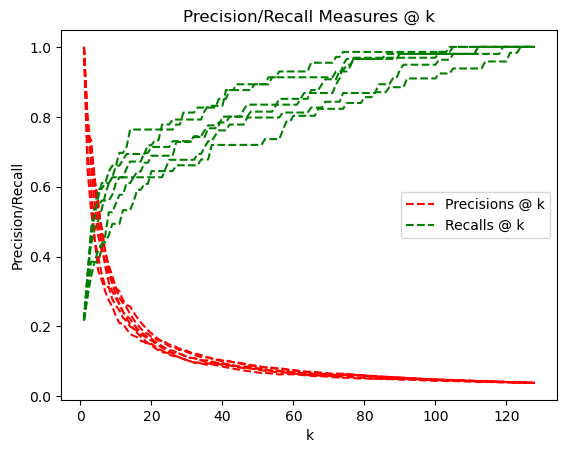

In [319]:
xs_k = np.arange(1, 129, 1)
ys_pk = list()
ys_rk = list()

for i in range(1, 129):
    arr_pk = np.asarray(dict_k_check["Euclidean"]["Default"]["Precision"][i])
    arr_rk = np.asarray(dict_k_check["Euclidean"]["Default"]["Recall"][i])
    y_pk = np.mean(arr_pk)
    y_rk = np.mean(arr_rk)
    ys_pk.append(y_pk)
    ys_rk.append(y_rk)

ys_pk2 = list()
ys_rk2 = list()

for i in range(1, 129):
    arr_pk = np.asarray(dict_k_check["Manhattan"]["Default"]["Precision"][i])
    arr_rk = np.asarray(dict_k_check["Manhattan"]["Default"]["Recall"][i])
    y_pk = np.mean(arr_pk)
    y_rk = np.mean(arr_rk)
    ys_pk2.append(y_pk)
    ys_rk2.append(y_rk)

ys_pk3 = list()
ys_rk3 = list()

for i in range(1, 129):
    arr_pk = np.asarray(dict_k_check["Cosine"]["Default"]["Precision"][i])
    arr_rk = np.asarray(dict_k_check["Cosine"]["Default"]["Recall"][i])
    y_pk = np.mean(arr_pk)
    y_rk = np.mean(arr_rk)
    ys_pk3.append(y_pk)
    ys_rk3.append(y_rk)

ys_pk4 = list()
ys_rk4 = list()

for i in range(1, 129):
    arr_pk = np.asarray(dict_k_check["Euclidean"]["Optimal"]["Precision"][i])
    arr_rk = np.asarray(dict_k_check["Euclidean"]["Optimal"]["Recall"][i])
    y_pk = np.mean(arr_pk)
    y_rk = np.mean(arr_rk)
    ys_pk4.append(y_pk)
    ys_rk4.append(y_rk)

ys_pk5 = list()
ys_rk5 = list()

for i in range(1, 129):
    arr_pk = np.asarray(dict_k_check["Manhattan"]["Optimal"]["Precision"][i])
    arr_rk = np.asarray(dict_k_check["Manhattan"]["Optimal"]["Recall"][i])
    y_pk = np.mean(arr_pk)
    y_rk = np.mean(arr_rk)
    ys_pk5.append(y_pk)
    ys_rk5.append(y_rk)

ys_pk6 = list()
ys_rk6 = list()

for i in range(1, 129):
    arr_pk = np.asarray(dict_k_check["Cosine"]["Optimal"]["Precision"][i])
    arr_rk = np.asarray(dict_k_check["Cosine"]["Optimal"]["Recall"][i])
    y_pk = np.mean(arr_pk)
    y_rk = np.mean(arr_rk)
    ys_pk6.append(y_pk)
    ys_rk6.append(y_rk)

fig, ax = plt.subplots()
ax.set_xlabel("k")
ax.set_ylabel("Precision/Recall")
ax.set_title("Precision/Recall Measures @ k")
ax.plot(xs_k, ys_pk, "--r")
ax.plot(xs_k, ys_rk, "--g")
ax.plot(xs_k, ys_pk2, "--r")
ax.plot(xs_k, ys_rk2, "--g")
ax.plot(xs_k, ys_pk3, "--r")
ax.plot(xs_k, ys_rk3, "--g")
ax.plot(xs_k, ys_pk4, "--r")
ax.plot(xs_k, ys_rk4, "--g")
ax.plot(xs_k, ys_pk5, "--r")
ax.plot(xs_k, ys_rk5, "--g")
ax.plot(xs_k, ys_pk6, "--r")
ax.plot(xs_k, ys_rk6, "--g")
ax.legend(['Precisions @ k', 'Recalls @ k'])
plt.show()

<center><b>Figure 6.</b> Precision/Recall Measures @ k</center>

Based on this graph, it could be said that around 5 would be the best k, where there is an acceptable and balanced trade-off between precision and recall. Moreover, it could be said from this graph that there are great differences among the recall measures of the IR variants; on the other hand, the differences in the precision of the IR variants are small or minimal. Through the next table, the numerical differences would be highlighted and explored more.

<p><b>Table 25.</b></p>
<p><i>General Evaluation Metrics Table</i></p>

In [320]:
# Main Table for Metrics
df_final = pd.DataFrame(
    columns=[
        "Vectorizer Settings",
        "Distance Measure",
        "Average\n(Precision @ 5)",
        "Average\n(Recall @ 5)",
        "Average\n(F-score @ 5)",
        "Mean Average Precision (MAP)",
        "R-Precision",
        "AUC-PR (Averaged Eleven-Point)",
    ]
)
df_final.loc[0] = [
    "Default",
    "Euclidean (L2)",
    "{:0.2f}".format(default_euc_pave),
    "{:0.2f}".format(default_euc_rave),
    "{:0.2f}".format(default_euc_fone),
    "{:0.2f}".format(default_euc_map),
    "{:0.2f}".format(default_euc_rp),
    0.54,
]

df_final.loc[1] = [
    '"Optimal"',
    "Euclidean (L2)",
    "{:0.2f}".format(optimal_euc_pave),
    "{:0.2f}".format(optimal_euc_rave),
    "{:0.2f}".format(optimal_euc_fone),
    "{:0.2f}".format(optimal_euc_map),
    "{:0.2f}".format(optimal_euc_rp),
    0.52,
]

df_final.loc[2] = [
    "Default",
    "Manhattan (L1)",
    "{:0.2f}".format(default_man_pave),
    "{:0.2f}".format(default_man_rave),
    "{:0.2f}".format(default_man_fone),
    "{:0.2f}".format(default_man_map),
    "{:0.2f}".format(default_man_rp),
    0.43,
]

df_final.loc[3] = [
    '"Optimal"',
    "Manhattan (L1)",
    "{:0.2f}".format(optimal_man_pave),
    "{:0.2f}".format(optimal_man_rave),
    "{:0.2f}".format(optimal_man_fone),
    "{:0.2f}".format(optimal_man_map),
    "{:0.2f}".format(optimal_man_rp),
    0.44,
]

df_final.loc[4] = [
    "Default",
    "Cosine",
    "{:0.2f}".format(default_cos_pave),
    "{:0.2f}".format(default_cos_rave),
    "{:0.2f}".format(default_cos_fone),
    "{:0.2f}".format(default_cos_map),
    "{:0.2f}".format(default_cos_rp),
    0.58,
]

df_final.loc[5] = [
    '"Optimal"',
    "Cosine",
    "{:0.2f}".format(optimal_cos_pave),
    "{:0.2f}".format(optimal_cos_rave),
    "{:0.2f}".format(optimal_cos_fone),
    "{:0.2f}".format(optimal_cos_map),
    "{:0.2f}".format(optimal_cos_rp),
    0.57,
]

pretty_print(df_final)

,Vectorizer Settings,Distance Measure,Average (Precision @ 5),Average (Recall @ 5),Average (F-score @ 5),Mean Average Precision (MAP),R-Precision,AUC-PR (Averaged Eleven-Point)
0,Default,Euclidean (L2),0.50,0.54,0.51,0.53,0.56,0.54
1,"""Optimal""",Euclidean (L2),0.46,0.50,0.47,0.52,0.51,0.52
2,Default,Manhattan (L1),0.36,0.38,0.36,0.40,0.40,0.43
3,"""Optimal""",Manhattan (L1),0.40,0.42,0.40,0.43,0.44,0.44
4,Default,Cosine,0.56,0.59,0.57,0.57,0.59,0.58
5,"""Optimal""",Cosine,0.54,0.57,0.55,0.57,0.59,0.57


As seen above, comparing the metrics between Default and "Optimal", it can be said that the "optimal" IR mostly underperforms as compared to the IR with default settings in its vectorizer. This may hint at how having a dataset with relatively few data points would not require much tuning as compared to a more extensive dataset. Moreover, cosine distance outperforms all the other distance measure, making it the best distance measure to use for the dataset. 

Interpreting each evaluation metric,
<ul>
    <li>Comparing both the MAP and the Average (Precision @ 5), given that MAP is known to fully represent all queries with its measure (Cambridge UP, 2009), it could be said that the selected k, based on the previous figure, approaches the best threshold for the IR, where precision and recall are in a good balance.</li>
    <li>Moreover, for k equal to 5, it could be noted that given a precision of around 0.40-0.50 which means that the results of the IR system are 40 to 50% relevant, the model is able to return about 50% of the relevant documents, as evidenced by the Average (Recall @ 5). This may imply that on average, the system is able to churn out most of the relevant documents for some queries, but fails to retrieve do so for other queries. This could be linked to the inequal distribution of the data points, which would be discussed in detail later.</li>
    <li>Lastly, R-Precision, which can approximate the best recall and precision for each query, signifies that it would be easier to acquire a better accuracy, if there is ideally an equal distribution of relevant movies for each movie (e.g. through their genre, language, and such).</li>
</ul>
Concluding this part of the results, it could be said that (1) vectorizer settings should be changed mostly when dealing with highly extensive data, (2) cosine distance provides the best performance in the given dataset, which may mean that it is recommended to be used in movie recommendation systems, and (3) a more extensive and more equally distributed dataset would help in dealing with the issues of varying performance across queries.

<p><b>Table 26.</b></p>
<p><i>R-Precision per Setting, Distance Measure, and Genre</i></p>

In [321]:
# Main Table for Metrics
df_genre = pd.DataFrame(
    columns=[
        "Vectorizer Settings",
        "Distance Measure",
        "Drama",
        "Comedy",
        "Mystery and Thriller",
        "Horror",
        "Romance",
        "Action",
        "Sci-fi",
        "Adventure",
        "LGBTQA+",
        "Fantasy",
    ]
)

lst_settings = ['Default', 'Optimal', 'Default', 'Optimal', 'Default',
                'Optimal']
lst_distances = ['Euclidean', 'Euclidean', 'Manhattan', 'Manhattan',
                 'Cosine', 'Cosine']
for i in range(6):
    df_genre.loc[i] = [
        lst_settings[i],
        lst_distances[i],
        "{:0.2f}".format(dict_genre[lst_distances[i]][lst_settings[i]][0]),
        "{:0.2f}".format(dict_genre[lst_distances[i]][lst_settings[i]][1]),
        "{:0.2f}".format(dict_genre[lst_distances[i]][lst_settings[i]][2]),
        "{:0.2f}".format(dict_genre[lst_distances[i]][lst_settings[i]][3]),
        "{:0.2f}".format(dict_genre[lst_distances[i]][lst_settings[i]][4]),
        "{:0.2f}".format(dict_genre[lst_distances[i]][lst_settings[i]][5]),
        "{:0.2f}".format(dict_genre[lst_distances[i]][lst_settings[i]][6]),
        "{:0.2f}".format(dict_genre[lst_distances[i]][lst_settings[i]][7]),
        "{:0.2f}".format(dict_genre[lst_distances[i]][lst_settings[i]][8]),
        "{:0.2f}".format(dict_genre[lst_distances[i]][lst_settings[i]][9]),
    ]
df_genre

,Vectorizer Settings,Distance Measure,Drama,Comedy,Mystery and Thriller,Horror,Romance,Action,Sci-fi,Adventure,LGBTQA+,Fantasy
0,Default,Euclidean,0.67,0.50,0.67,0.40,0.29,0.50,0.50,1.00,0.75,0.33
1,Optimal,Euclidean,0.67,0.50,0.67,0.40,0.29,0.50,0.50,0.50,0.75,0.33
2,Default,Manhattan,0.50,0.25,0.33,0.20,0.29,0.50,0.25,0.75,0.75,0.17
3,Optimal,Manhattan,0.67,0.25,0.67,0.40,0.29,0.67,0.50,0.50,0.25,0.17
4,Default,Cosine,0.83,0.50,0.67,0.40,0.29,0.50,0.50,1.00,0.75,0.50
5,Optimal,Cosine,0.83,0.50,0.67,0.40,0.29,0.67,0.50,0.75,0.75,0.50


In Table 22, each genre is represented by a movie, and the R-Precision was used as it is able to take into account how much true relevant documents there are for a given query, and thus, can be used to compare queries with each other, given that their supposed ks are adjusted on a case-to-case basis. With regards to the table, the high population of drama may have contributed to the relatively average to high precision of drama, however, the genres that would contradict this are adventure and LGBTQA+, which have average representation in the dataset (based on their frequencies in the dataset) and which are able to return most to all of the relevant documents with a k equal to all the relevant documents. What this may signify is that the chosen movie for the genre is a good representative of all movies with the same genre, and moreover, the synopsis and critiques of these movie genre may make use of the same "vernacular" in writing, which may then allow for easier finding of similar, relevant movies to these movies. If it being a good representative is only the reason, in order to get a more impartial evaluation of the IR, it is better to acquire more "users" or queries to feed to the system, as to dampen the effects of the coincidentally highly representative queries.

Hence, it could be said from this that while a high number of datapoints, where more relevant features may be derived, may help in raising accuracy; having relatively less data points for a given characteristic of the data points would not immediately lead to having lower accuracy for that characteristic. This may still depend on the features derived from these data points and the "coincidental" well-representativeness of the chosen query.

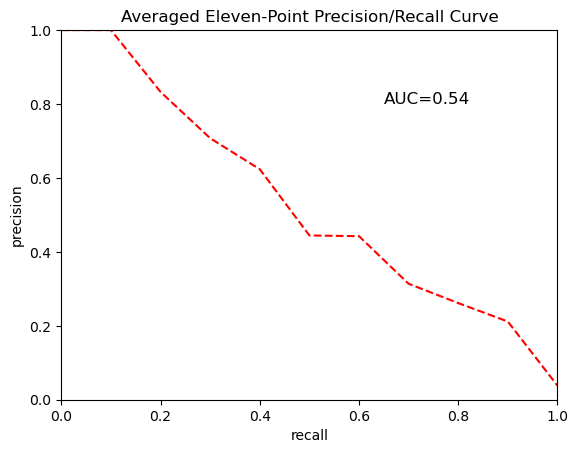

In [322]:
# Eleven-Point Precision/Recall Curve
# Default Euclidean
ave_prg(queries['Default'], data_default, euclidean, 1, gold_standards)
plt.show()

<center><b>Figure 7.</b> Averaged Eleven-Point PR Curve (Default Euclidean)</center>

Seen above is a usual trend for PR curves where precision tends to go down as recall goes up, and vice-versa. What could be noted here is that the IR system using these settings can immediately churn out relevant movies, however, it tends to underperform as more results are returned. The coordinates (0.5, 0.5) serves as the best trade-off for both metrics, however, given that precision is more desired than recall, lowering the recall or k may help in furthering this goal of higher precision.

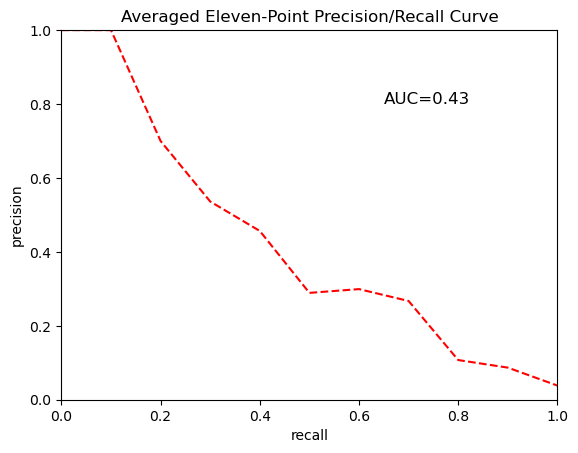

In [323]:
# Default Manhattan
ave_prg(queries['Default'], data_default, cityblock, 1, gold_standards)
plt.show()

<center><b>Figure 8.</b> Averaged Eleven-Point PR Curve (Default Manhattan)</center>

There is a similar trend, however, using the Manhattan distance makes the IR system underperform, as evidenced by the lower area under the curve.

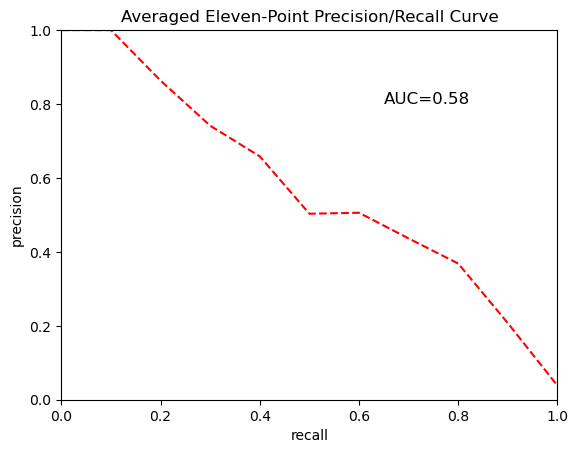

In [324]:
# Default Cosine
ave_prg(queries['Default'], data_default, cosine, 1, gold_standards)
plt.show()

<center><b>Figure 9.</b> Averaged Eleven-Point PR Curve (Default Cosine)</center>

As seen in the figure above, using the cosine distance provides a relatively area under the curve, and so, unlike the PR curve for default euclidean, it could be said that the recall or k could be raised higher, while still being able to provide a relatively high amount of precision.

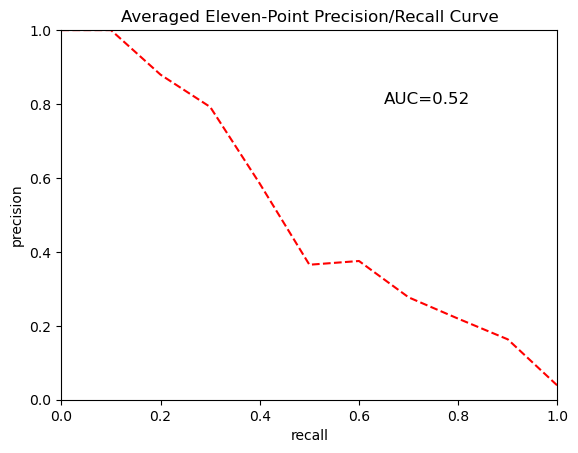

In [325]:
# Optimal Euclidean
ave_prg(queries['Optimal'], data_optimal, euclidean, 1, gold_standards)
plt.show()

<center><b>Figure 10.</b> Averaged Eleven-Point PR Curve (Optimal Euclidean)</center>

There are no unusual observations for this figure, except for the fact that "optimizing" the settings for the vectorizer led to a lower area under the curve, and thus, lower leverage in lowering the recall to increase the precision.

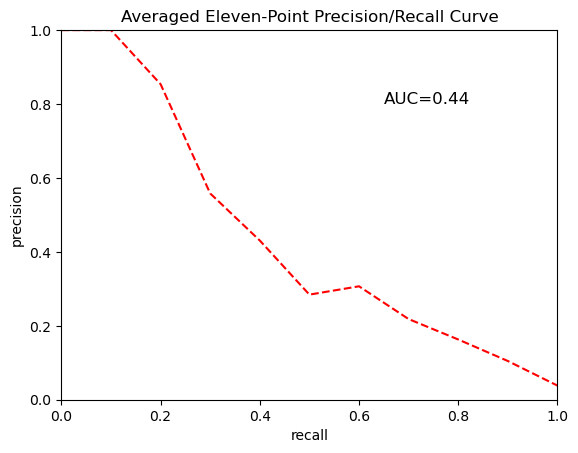

In [326]:
# Optimal Manhattan
ave_prg(queries['Optimal'], data_optimal, cityblock, 1, gold_standards)
plt.show()

<center><b>Figure 11.</b> Averaged Eleven-Point PR Curve (Optimal Manhattan)</center>

There are no unusual observations for this figure, except for the fact that "optimizing" the settings for the vectorizer actually led to a miniscule increase in the area under the curve, for Manhattan distance.

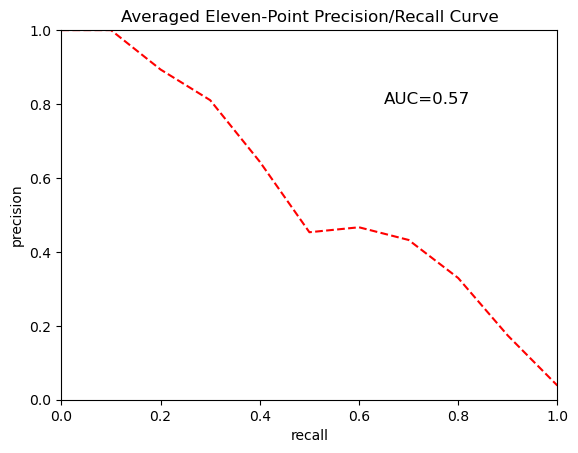

In [327]:
# Optimal Cosine
ave_prg(queries['Optimal'], data_optimal, cosine, 1, gold_standards)
plt.show()

<center><b>Figure 12.</b> Averaged Eleven-Point PR Curve (Optimal Cosine)</center>

Similarly, there are no interesting observations for the given graph, except for the fact that "optimizing" the vectorizer led to a miniscule decrease in the area under the curve and for the more apparent "kink" around recall equal to 0.5, where this may signify a slight increase in precision, even with the increase in recall. The significance of this is that it can be used as an argument to further increase the would-be k by a small margin, given that precision can still increase even if there is a slight increase in recall.

Hence, the best Information Retrieval System would be the Default Cosine at k = 5, given its relatively high performance as compared to the other variants. To see this system in action, go to the notebook if you are viewing the HTML version of the report, feel free to select from the dropdown menus the number of results (k) and movie title to search similar movies for, and click `Search` to acquire a list of results deemed relevant by the system.

In [328]:
search_k_title()

Dropdown(description='k', index=4, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,…

Dropdown(description='Movie Title', options=('Afire', 'A Thousand and One', 'A Million Miles Away', 'Attachmen…

Button(button_style='success', description='Search', style=ButtonStyle())

Output()

[Back to TOC](#TContents)

<a id='Conclusion'></a>
<h1 style="color:#ffffff; background-color:#E44728; border: 1px solid #ffffff; padding: 10px 10px 10px 10px;">VII. CONCLUSION</h1>

<p>In conclusion,</p>
<ul>
    <li>The best Information Retrieval System is the Default Cosine at k = 5. The facts regarding this are expounded below.</li>
    <li>Changing the settings for the vectorizer is most appropriate when dealing with highly extensive and large datasets, as compared to dealing with relatively few data points. As exemplified in this laboratory experiment, there were mostly lower accuracies, when the "optimizations" were added, and mostly higher accuracies when the default settings were used.</li>
    <li>Returning results where recall is equal to around 0.5 and where k is around 5 (as advised by the Precision-Recall vs. k graph) would provide the best trade-off between precision and recall, where both would be around 0.5. This is feasible for a small-scale recommendation system, where this could be often found in the parts of movie review websites which state "If you like this movie, we recommend these movies too".</li>
    <li>For movie recommendation systems, systems which make use of textual data, and IR systems which make use of similar data (size, theme, features, e.g.), using cosine distance is recommended as it provided the highest accuracy out of all distance measures.</li>
    <li>Using highly extensive and larger datasets may lead to higher accuracies, as it increases the chances of equal distribution among data points, of acquiring well-representative, relevant, and useful features, and of having more relevant data points for a given query.</li>
    <li>Lastly, coincidentally selecting a highly representative query or exemplar would possibly provided highly-skewed accuracy scores, and so, it is recommended to acquire more "users" or queries to use in evaluating the system as to get "truer" or more genuine evaluation metrics.</li>
</ul>
    
[Back to TOC](#TContents)

<a id='Recommendation'></a>
<h1 style="color:#ffffff; background-color:#E44728; border: 1px solid #ffffff; padding: 10px 10px 10px 10px;">VIII. RECOMMENDATION</h1>

<p>Some recommendations for further improvement of this project and if this project would be replicated are:</p>
<ol>
    <li>Create hypotheses for each change in setting as to ascertain which setting may be improving the performance of the IR system instead of lumping all changes together and comparing them against the control.</li>
    <li>Increase the size of the dataset as to accomodate other movies and to further tune or refine the ability of the IR system to recognize similar or relevant movies, through the introduction of more representative features and more representative data points.</li>
    <li>Increase the number of queries as to avoid the skewing of the evaluation metrics and to reduce the possibilities of acquring mostly representative or less representative queries.</li>
    <li>Moreover, hiring or outsourcing a number of "movie watchers" would help in further refining the gold standard and in further improving the subjective question of which is relevant or not.</li>
    <li>Compare other distance measures with the cosine distance as the point of comparison. This is to further study whether cosine distances are indeed the best metric for text-based information retrieval, movie recommendation systems, or datasets which are similar to the one used in the study.</li>
</ol>

[Back to TOC](#TContents)

<a id='Acknowledgment'></a>
<h1 style="color:#ffffff; background-color:#E44728; border: 1px solid #ffffff; padding: 10px 10px 10px 10px;">ACKNOWLEDGMENT</h1>

We express our heartfelt gratitude to our parents, family, and friends for their unwavering support throughout our data science journey. Additionally, we extend our sincere thanks to Professor Alis and all our esteemed professors for their continuous inspiration, fostering our curiosity in the field of data science, and encouraging us to always seek new knowledge.

A special note of appreciation goes to Professor Alis for his dedicated guidance. We are thankful for the thought-provoking problem sets and exercises he provides, which have significantly contributed to our practical understanding and skills in the realm of data science. His commitment to our academic development has been instrumental, and we are grateful for the invaluable learning experiences he has facilitated.

[Back to TOC](#TContents)

<a id='References'></a>
<h1 style="color:#ffffff; background-color:#E44728; border: 1px solid #ffffff; padding: 10px 10px 10px 10px;">REFERENCES</h1>

<a name='Intro'></a>[1] Cambridge UP. (2008). <i>Assessing Relevance.</i> Retrieved from https://nlp.stanford.edu/IR-book/html/htmledition/assessing-relevance-1.html

[2] Cambridge UP. (2009). <i>Introduction to Information Retrieval - Chapter 8: Evaluation in Information Retrieval.</i> Retrieved from https://nlp.stanford.edu/IR-book/pdf/08eval.pdf

[3] Ganesan, K. (n.d.). <i>Tips for Constructing Custom Stop Word Lists.</i> Retrieved from https://kavita-ganesan.com/tips-for-constructing-custom-stop-word-lists/

[4] Ganesan, K. (n.d.). <i>How to Use CountVectorizer.</i> Retrieved from https://kavita-ganesan.com/how-to-use-countvectorizer/ 

[5] Inside Learning Machines. (n.d.). <i>Precision@K and Recall@K.</i> Retrieved from https://insidelearningmachines.com/precisionk_and_recallk/

[6] Manning, C. D., Raghavan, P., & Schütze, H. (n.d.). <i>Evaluation of Ranked Retrieval Results.</i> Retrieved from https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-ranked-retrieval-results-1.html

[7] Nandeshwar. (2022). <i>Mean Average Precision (MAP) - K Metric Explained + Code.</i> Retrieved from https://www.kaggle.com/code/nandeshwar/mean-average-precision-map-k-metric-explained-code

[8] Northeastern University Khoury College of Computer Sciences. (2015). <i>Information Retrieval User Study: Evaluation (Lecture Notes).</i> Retrieved from https://www.khoury.northeastern.edu/home/vip/teach/IRcourse/5_eval_userstudy/lecture_notes/IR_V6.pdf 

[9] PopFlick. (n.d.). <i>Film Industry Statistics.</i> Retrieved from https://www.popflick.com/film-industry-statistics

[10] PracticeProbs. (n.d.). <i>Precision and Recall.</i> Retrieved from https://www.practiceprobs.com/problemsets/metrics/precision-and-recall/#average-precision-at-k-apk

[11] Towards Data Science. (2023). <i>Evaluation Metrics for Recommendation Systems: An Overview.</i> Retrieved from https://towardsdatascience.com/evaluation-metrics-for-recommendation-systems-an-overview-71290690ecba

[12] University of Cambridge Computer Laboratory. (n.d.). <i>Lecture 5: Evaluation (Information Retrieval).</i> Retrieved from https://www.cl.cam.ac.uk/teaching/1415/InfoRtrv/lecture5.pdf

[13] Zhang, E., Zhang, Y. (2009). <i>Eleven Point Precision-recall Curve.</i> In: LIU, L., ÖZSU, M.T. (eds) Encyclopedia of Database Systems. Springer, Boston, MA. https://doi.org/10.1007/978-0-387-39940-9_481

[Back to TOC](#TContents)